# UAE Property Data Set - Notebook Objective

## Business Overview

The property market in the UAE is often volatile and competitive. Agents frequently incur time and operational costs on logistics, only to find that a sale doesn't transact, or that the property is challenging to sell. Moreover, there is limited knowledge about property price distribution within specific areas of a city or when is the best time to buy or sell.

Similarly, banks need accurate property valuations to align loans with market value. Companies offering valuation services often struggle to justify their numbers. 

Both buyers and sellers can benefit from information derived from the datasets below, even from an exploratory data analysis (EDA) perspective. Easy-to-understand EDA objectives are often more valuable to the average end user than predictive models. However, the dataset has been cleaned for both EDA and predictive purposes, allowing users to build models for their own needs.

## Notebook Structure

1. **Data Cleaning**:  
   Clean the data into a more readable and expanded format that can be used in machine learning models to gain insights into the UAE market from this limited web scrape.

2. **Feature Engineering**:  
   Split and extract usable information from columns, and create new features from the extracted data.

3. **Exploratory Data Analysis (EDA)**:  
   Perform some EDA to uncover trends and insights.

4. **Set Up for Regression Model**:  
   Prepare the dataset for a regression model to predict property selling prices based on the extracted features.


In [81]:
import pandas as pd
import re

In [82]:

df=pd.read_csv('/kaggle/input/real-estate-data-uae/uae_properties.csv')

In [83]:
#check the load of the data to ensure it is has been loaded correctly
df.head()

,id,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price
0,10837871,★ EXCLUSIVE RELEASE ★ | LUXURY 3 BED FLAT | GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06T17:05:24+00:00,buy,817185656.00,apartment,3950000
1,10880180,"★ BUY NOW 624,000AED ★ (20% FIRST PAYMENT + 4%...","Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13T21:19:31+00:00,buy,817185656.00,apartment,2600000
2,11220200,GREEN HEART OF DUBAI |URBAN DESIGN | LUXURY LI...,"Park Horizon, Dubai Hills Estate, Dubai",2,3,2024-03-12T03:18:54+00:00,buy,2125965775.00,apartment,3450000
3,11176502,Prime Location | Corner Spacious Unit | Bright...,"AZIZI Riviera, Meydan One, Meydan, Dubai",2,3,2024-03-04T06:53:51+00:00,buy,71149777382.00,apartment,2000000
4,11179908,Very Limited | Ideal For Investment | 40% Disc...,"Verdana, Dubai Investment Park, Dubai",2,0,2024-03-04T13:24:39+00:00,buy,465261649.00,apartment,284000


In [84]:
#check the end of the dataframe for errors or missing rows poor indexing.
df.tail()

,id,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price
487,11221319,Best Offer | Limited 3 Bed | Furnished Serviced,"North 43 Residences, Jumeirah Village Circle, ...",2,3,2024-03-12T08:31:25+00:00,buy,456027703.00,apartment,1914927
488,10837884,LUXURY FLAT | GOLDEN VISA | GREAT VIEW | FLEXI...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-06T17:09:49+00:00,buy,817185656.00,apartment,2650000
489,11134630,Magnificent| Luxurious l High ROI,"310 Riverside Crescent, Sobha Hartland II, Moh...",2,3,2024-02-26T06:31:21+00:00,buy,173353897.00,apartment,2191944
490,11151144,Full Burj Khalifa | High Floor | Confirm Seller,"Boulevard Point, Downtown Dubai, Dubai",2,3,2024-02-28T07:11:49+00:00,buy,6512527887.00,apartment,6600000
491,10615925,Invest in this Modern Unit For Your Family!,"Ansam 1, Ansam, Yas Island, Abu Dhabi",2,0,2023-11-22T09:40:55+00:00,buy,NaN,apartment,850000


In [85]:
#check that there are no repeat ID numbers in here compared to above shape
df.id.nunique()

492

In [86]:
#check the datatypes of the untouched dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              492 non-null    int64  
 1   title           492 non-null    object 
 2   displayAddress  492 non-null    object 
 3   bathrooms       492 non-null    int64  
 4   bedrooms        492 non-null    int64  
 5   addedOn         492 non-null    object 
 6   type            492 non-null    object 
 7   rera            323 non-null    float64
 8   propertyType    492 non-null    object 
 9   price           492 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 38.6+ KB


## Dataset Overview

### Key Observations

- **Unique Property IDs**:  
  Every property has a unique ID number—no duplicates!

- **Messy Titles**:  
  The titles are inconsistent and contain various pieces of information that could be better organized into separate columns.

- **Address Format**:  
  The address column has location data separated by commas (e.g., "Dubai, Downtown"). This can be split up to better organize the location details.

- **Bedrooms and Bathrooms**:  
  Bedrooms and bathrooms are counted as whole numbers (e.g., 1, 2, 3).

- **Listing Dates ("Added on" column)**:  
  The "Added on" column shows when properties were listed, but the dates aren't formatted correctly. We'll need to clean this up to make them usable.

- **Mixed Types**:  
  The "Type" column seems to have various types mixed together, requiring some standardization.

- **RERA Column**:  
  This column contains contract numbers, but it's not very useful for analysis purposes.

- **Property Type**:  
  This column provides straightforward information about the type of property (e.g., apartment, villa).

- **Price**:  
  The price, which we want to predict using machine learning models, is stored as a whole number.


## Title Column Cleanup

To clean up the **Title** column, we'll follow these steps:

1. **Remove Extra Characters/Symbols**:  
   Strip away any unnecessary characters, punctuation, or symbols.

2. **Identify Common Keywords**:  
   Find the most frequently occurring words that appear in the titles.

3. **Extract Repeated Keywords**:  
   Pull out these recurring keywords from the messy text obtained via web scraping.


In [87]:
import re
import string
import pandas as pd
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

class TextPreprocessor:
    """A class to handle text preprocessing tasks including cleaning and word frequency analysis."""
    
    def __init__(self):
        # Download required NLTK resources
        nltk.download('punkt')
        nltk.download('stopwords')
        
        self.stop_words = set(stopwords.words())
        
        # Emoji pattern for removal
        self.emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
    
    def clean_text(self, text):
        """
        Clean and preprocess text data.
        
        Args:
            text (str): Input text to be cleaned
            
        Returns:
            str: Cleaned and preprocessed text
        """
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub('https?://\S+|www\.\S+', '', text)
        
        # Remove HTML tags
        text = re.sub('<.*?>', '', text)
        
        # Remove punctuation
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        
        # Remove newlines and special quotes
        text = re.sub('\n', ' ', text)
        text = re.sub('["""…]', '', text)
        
        # Remove emojis
        text = self.emoji_pattern.sub('', text)
        
        # Tokenize and remove stop words
        tokens = word_tokenize(text)
        tokens_without_stopwords = [word for word in tokens if word not in self.stop_words]
        
        return ' '.join(tokens_without_stopwords)
    
    def get_word_frequencies(self, df, text_column, top_n=50, max_rows=None):
        """
        Calculate word frequencies from a DataFrame column.
        
        Args:
            df (pandas.DataFrame): Input DataFrame
            text_column (str): Name of the column containing text
            top_n (int): Number of top frequent words to return
            max_rows (int): Maximum number of rows to process (None for all rows)
            
        Returns:
            pandas.DataFrame: DataFrame containing word frequencies
        """
        # Subset DataFrame if max_rows is specified
        if max_rows is not None:
            df = df.head(max_rows)
        
        # Clean all texts in the column
        cleaned_texts = df[text_column].apply(self.clean_text)
        
        # Calculate word frequencies
        word_count = Counter(' '.join(cleaned_texts).split()).most_common(top_n)
        
        return pd.DataFrame(word_count, columns=['Word', 'Frequency'])

def main():
    # Initialize preprocessor
    preprocessor = TextPreprocessor()
    
    # Read data
    max_rows = 1000  # Set to None to read entire file
    df = pd.read_csv(
        '/kaggle/input/real-estate-data-uae/uae_properties.csv',
        nrows=max_rows,
        engine='python'
    )
    
    # Get word frequencies
    word_frequency = preprocessor.get_word_frequencies(
        df=df,
        text_column='title',
        top_n=50,
        max_rows=max_rows
    )
    
    print(word_frequency)

if __name__ == "__main__":
    main()

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
          Word  Frequency
0         view        139
1         high         86
2      payment         74
3         plan         58
4          roi         54
5     location         53
6    furnished         53
7            3         51
8        floor         46
9       luxury         45
10       fully         44
11       prime         39
12   apartment         38
13        unit         35
14       ready         34
15    spacious         31
16         3br         31
17  investment         30
18       brand         29
19      vacant         29
20        pool         28
21        deal         28
22           1         27
23      modern         26
24       views         26
25        burj         24
26   community         23
27          10         23
28           5  

## Comments on Count and NLTK Processing of the Title Column

1. **Useful Keyword**:  
   The most useful keyword identified in the titles is "views."

2. **Add Furnished Info**:  
   We'll add a **"Furnished"** column to the dataset, as it could impact the price of a unit.

3. **Add Pool Info**:  
   We'll create a new boolean column for properties with **pool** entries, as this may also affect the price relationship.


In [88]:
#check the shape of the dataset 
df.shape

(492, 10)

In [89]:
#check datatypes of the dataframe for issues.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              492 non-null    int64  
 1   title           492 non-null    object 
 2   displayAddress  492 non-null    object 
 3   bathrooms       492 non-null    int64  
 4   bedrooms        492 non-null    int64  
 5   addedOn         492 non-null    object 
 6   type            492 non-null    object 
 7   rera            323 non-null    float64
 8   propertyType    492 non-null    object 
 9   price           492 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 38.6+ KB


In [90]:
# Remove emojis and other special characters while preserving letters, numbers, and spaces
df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]|[^\x00-\x7F]+', ' ', str(x)))

In [91]:
#checking if the stars have been removed
df.head(5)

,id,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price
0,10837871,EXCLUSIVE RELEASE LUXURY 3 BED FLAT GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06T17:05:24+00:00,buy,817185656.00,apartment,3950000
1,10880180,BUY NOW 624 000AED 20 FIRST PAYMENT 4 ...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13T21:19:31+00:00,buy,817185656.00,apartment,2600000
2,11220200,GREEN HEART OF DUBAI URBAN DESIGN LUXURY LI...,"Park Horizon, Dubai Hills Estate, Dubai",2,3,2024-03-12T03:18:54+00:00,buy,2125965775.00,apartment,3450000
3,11176502,Prime Location Corner Spacious Unit Bright...,"AZIZI Riviera, Meydan One, Meydan, Dubai",2,3,2024-03-04T06:53:51+00:00,buy,71149777382.00,apartment,2000000
4,11179908,Very Limited Ideal For Investment 40 Disc...,"Verdana, Dubai Investment Park, Dubai",2,0,2024-03-04T13:24:39+00:00,buy,465261649.00,apartment,284000


## Data Cleaning 02

1. **Expand Comma-Separated Values**:  
   Split the location data (currently comma-separated) into their own columns to improve the exploratory data analysis (EDA) based on locations.


In [92]:
# Expand the 'displayAddress' column by splitting at commas
col2_expanded = df['displayAddress'].str.split(",", expand=True)

# Create a new dataframe by merging the 'id' column with the expanded address columns
df2 = pd.concat([df['id'], col2_expanded], axis=1)


In [93]:
#check the head of the dataframe to be sure the column string split was successful.
df2.head()

,id,0,1,2,3
0,10837871,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai
1,10880180,Sobha Verde,Jumeirah Lake Towers,Dubai,None
2,11220200,Park Horizon,Dubai Hills Estate,Dubai,None
3,11176502,AZIZI Riviera,Meydan One,Meydan,Dubai
4,11179908,Verdana,Dubai Investment Park,Dubai,None


## Observations on Expanded Dataset

1. **Index Retained**:  
   We retained the original index using the **ID** and added four separate columns based on the comma-separated values from the original "display address" column.

2. **Separation Outcome**:  
   This separation was mostly useful, but further cleaning is likely required. Some city names are misplaced, and there are missing entries in the far-right column.


In [94]:
#check the shape before we join these two dataframes into one
df2.shape

(492, 5)

In [95]:
df2.info

<bound method DataFrame.info of            id                       0                         1  \
0    10837871               Sobha One            Sobha Hartland   
1    10880180             Sobha Verde      Jumeirah Lake Towers   
2    11220200            Park Horizon        Dubai Hills Estate   
3    11176502           AZIZI Riviera                Meydan One   
4    11179908                 Verdana     Dubai Investment Park   
..        ...                     ...                       ...   
487  11221319     North 43 Residences   Jumeirah Village Circle   
488  10837884             Sobha Verde      Jumeirah Lake Towers   
489  11134630  310 Riverside Crescent         Sobha Hartland II   
490  11151144         Boulevard Point            Downtown Dubai   
491  10615925                 Ansam 1                     Ansam   

                             2           3  
0     Mohammed Bin Rashid City       Dubai  
1                        Dubai        None  
2                        Dub

In [96]:
# Check if 'id' exists in our dataframes first
print("Columns in df:", df.columns)
print("Columns in location_details:", df2.columns)

# Join the dataframes correctly
df = df.set_index('id').join(
    df2.drop('id', axis=1).set_index(df2['id'])
)

Columns in df: Index(['id', 'title', 'displayAddress', 'bathrooms', 'bedrooms', 'addedOn',
       'type', 'rera', 'propertyType', 'price'],
      dtype='object')
Columns in location_details: Index(['id', 0, 1, 2, 3], dtype='object')


In [97]:
#check the head to see if the dataframes were joined properly.
df.head(2)

,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price,0,1,2,3
id,,,,,,,,,,,,,
10837871,EXCLUSIVE RELEASE LUXURY 3 BED FLAT GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06T17:05:24+00:00,buy,817185656.00,apartment,3950000,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai
10880180,BUY NOW 624 000AED 20 FIRST PAYMENT 4 ...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13T21:19:31+00:00,buy,817185656.00,apartment,2600000,Sobha Verde,Jumeirah Lake Towers,Dubai,None


In [98]:
# Rename columns for better readability and use in analysis
df.rename(columns={0: 'sub_development', 1: 'main_development', 2: 'area', 3: 'city'}, inplace=True)

# Update the 'city' column where 'area' contains 'Dubai', and remove 'Dubai' from the 'area' column
df.loc[df['area'].str.contains('Dubai', na=False), 'city'] = 'Dubai'
df['area'] = df['area'].str.replace('Dubai', '')

# Update the 'city' column where 'area' contains 'Abu Dhabi', and remove 'Abu Dhabi' from the 'area' column
df.loc[df['area'].str.contains('Abu Dhabi', na=False), 'city'] = 'Abu Dhabi'
df['area'] = df['area'].str.replace('Abu Dhabi', '')

# Update the 'city' column where 'area' contains 'Ras Al Khaimah', and remove 'Ras Al Khaimah' from the 'area' column
df.loc[df['area'].str.contains('Ras Al Khaimah', na=False), 'city'] = 'Ras Al Khaimah'
df['area'] = df['area'].str.replace('Ras Al Khaimah', '')

# Update the 'city' column where 'area' contains 'Sharjah', and remove 'Sharjah' from the 'area' column
df.loc[df['area'].str.contains('Sharjah', na=False), 'city'] = 'Sharjah'
df['area'] = df['area'].str.replace('Sharjah', '')

# Update the 'city' column where 'area' contains 'Ajman', and remove 'Ajman' from the 'area' column
df.loc[df['area'].str.contains('Ajman', na=False), 'city'] = 'Ajman'
df['area'] = df['area'].str.replace('Ajman', '')

# Strip leading whitespace from the 'area' column to standardize the data
df['area'] = df['area'].str.lstrip()

# Strip leading whitespace from the 'city' column to standardize the data
df['city'] = df['city'].str.lstrip()

# Strip leading whitespace from the 'sub_development' column to standardize the data
df['sub_development'] = df['sub_development'].str.lstrip()

# Strip leading whitespace from the 'main_development' column to standardize the data
df['main_development'] = df['main_development'].str.lstrip()


In [99]:
#check there are now no duplicate entries due to a whitespace in front of the entry in the area column.
df.area.value_counts()

area
                               299
Al Reem Island                  35
Downtown                        12
Meydan                          11
Muwaileh                        11
Business Bay                    11
Jumeirah Lake Towers             7
Greens                           7
Mohammed Bin Rashid City         6
Jumeirah Beach Residence         6
Town Square                      6
Wasl Gate                        6
South ( World Central)           5
The World Islands                4
Yas Island                       4
Al Kifaf                         4
Al Marjan Island                 4
Creek Harbour (The Lagoons)      3
Marina                           3
Harbour                          3
Palm Jumeirah                    3
Mina Al Arab                     3
Aljada                           2
Production City (IMPZ)           2
Al Furjan                        2
Al Hamriyah                      2
Maritime City                    2
City Walk                        2
Umm Suqeim     

In [100]:
#check spacing errors have been removed from the city column.
df.city.value_counts()

city
Dubai             307
Abu Dhabi         118
Sharjah            38
Ras Al Khaimah     13
Ajman               4
Name: count, dtype: int64

In [101]:
#check spacing errors have been removed from the sub development column.
df.sub_development.value_counts()

sub_development
Reeman Living                26
Reeman Living II             15
Diva                         12
Binghatti Crest              11
Radiant Boulevard            11
                             ..
Palace Residences             1
Palace Residences - North     1
Meera                         1
The Palm Tower                1
Ansam 1                       1
Name: count, Length: 249, dtype: int64

In [102]:
#check spacing errors have been removed from the main development column.
df.main_development.value_counts()

main_development
Jumeirah Village Circle    44
Al Shamkha                 43
City Of Lights             22
Yas Island                 20
Arjan                      14
                           ..
Dubai Studio City           1
Pacific                     1
Al Maryah Island            1
Emirates Hills 2            1
Ansam                       1
Name: count, Length: 128, dtype: int64

## Data Cleaning 03

1. **Convert "Added On" to DateTime Format**:  
   Change the "Added on" column to a proper datetime format for better usability.

2. **Add "Date Month" Column**:  
   Create a new **"Date Month"** column to provide temporal insights, enhancing the dataset for time-based analysis.


In [103]:
# Convert 'addedOn' column to datetime format to work with date-specific operations
df['addedOn'] = pd.to_datetime(df['addedOn'])

# Define a list of month names for readability
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Extract the month number from the 'addedOn' column and map it to the corresponding month name
df['month_added'] = df['addedOn'].dt.month.map(lambda x: month_names[x-1])

# Now 'month_added' contains the full names of the months


In [104]:
#check the dataframe to be sure the months are now added as an additional column.
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price,sub_development,main_development,area,city,month_added
id,,,,,,,,,,,,,,
10837871,EXCLUSIVE RELEASE LUXURY 3 BED FLAT GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06 17:05:24+00:00,buy,817185656.00,apartment,3950000,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai,January
10880180,BUY NOW 624 000AED 20 FIRST PAYMENT 4 ...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13 21:19:31+00:00,buy,817185656.00,apartment,2600000,Sobha Verde,Jumeirah Lake Towers,,Dubai,January
11220200,GREEN HEART OF DUBAI URBAN DESIGN LUXURY LI...,"Park Horizon, Dubai Hills Estate, Dubai",2,3,2024-03-12 03:18:54+00:00,buy,2125965775.00,apartment,3450000,Park Horizon,Dubai Hills Estate,,Dubai,March
11176502,Prime Location Corner Spacious Unit Bright...,"AZIZI Riviera, Meydan One, Meydan, Dubai",2,3,2024-03-04 06:53:51+00:00,buy,71149777382.00,apartment,2000000,AZIZI Riviera,Meydan One,Meydan,Dubai,March
11179908,Very Limited Ideal For Investment 40 Disc...,"Verdana, Dubai Investment Park, Dubai",2,0,2024-03-04 13:24:39+00:00,buy,465261649.00,apartment,284000,Verdana,Dubai Investment Park,,Dubai,March


In [105]:
#checking the datatypes to be sure datatime has been transferred properly and that months are an integer datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492 entries, 10837871 to 10615925
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   title             492 non-null    object             
 1   displayAddress    492 non-null    object             
 2   bathrooms         492 non-null    int64              
 3   bedrooms          492 non-null    int64              
 4   addedOn           492 non-null    datetime64[ns, UTC]
 5   type              492 non-null    object             
 6   rera              323 non-null    float64            
 7   propertyType      492 non-null    object             
 8   price             492 non-null    int64              
 9   sub_development   492 non-null    object             
 10  main_development  492 non-null    object             
 11  area              480 non-null    object             
 12  city              480 non-null    object             
 13

## Feature Engineering 01

1. **Add 'view' Column**:  
   Create a boolean column **'view'** using the `str.contains` function to detect the keyword "view" (case-insensitive) in the title column.

2. **Add 'view2' Column**:  
   Create a second boolean column **'view2'** using the `str.contains` function for capitalized "View" in the title column.

3. **Combine Columns**:  
   Add the **'view'** and **'view2'** columns together to consolidate the view-related data.

4. **Map Results to Numeric**:  
   Map the combined results into numeric values where **1** indicates "yes" (view present) and **0** indicates "no" (view absent).


In [106]:
import numpy as np

# Create a new column 'view' based on the presence of the keyword 'View' in the 'title' column
df['view'] = np.where(df['title'].str.contains('View', case=False, regex=False), 'view', 'no data')


In [107]:
#checking if the 'view' column is added succesfully.
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price,sub_development,main_development,area,city,month_added,view
id,,,,,,,,,,,,,,,
10837871,EXCLUSIVE RELEASE LUXURY 3 BED FLAT GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06 17:05:24+00:00,buy,817185656.00,apartment,3950000,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai,January,no data
10880180,BUY NOW 624 000AED 20 FIRST PAYMENT 4 ...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13 21:19:31+00:00,buy,817185656.00,apartment,2600000,Sobha Verde,Jumeirah Lake Towers,,Dubai,January,no data
11220200,GREEN HEART OF DUBAI URBAN DESIGN LUXURY LI...,"Park Horizon, Dubai Hills Estate, Dubai",2,3,2024-03-12 03:18:54+00:00,buy,2125965775.00,apartment,3450000,Park Horizon,Dubai Hills Estate,,Dubai,March,no data
11176502,Prime Location Corner Spacious Unit Bright...,"AZIZI Riviera, Meydan One, Meydan, Dubai",2,3,2024-03-04 06:53:51+00:00,buy,71149777382.00,apartment,2000000,AZIZI Riviera,Meydan One,Meydan,Dubai,March,no data
11179908,Very Limited Ideal For Investment 40 Disc...,"Verdana, Dubai Investment Park, Dubai",2,0,2024-03-04 13:24:39+00:00,buy,465261649.00,apartment,284000,Verdana,Dubai Investment Park,,Dubai,March,no data


In [108]:
#extracting a different spelling to create a second views column and eventually merge the data together
df['view2']=np.where(df['title'].str.contains('Views', regex= False), "view", 'no data')

In [109]:
#checking columns have been added properly.
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price,sub_development,main_development,area,city,month_added,view,view2
id,,,,,,,,,,,,,,,,
10837871,EXCLUSIVE RELEASE LUXURY 3 BED FLAT GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06 17:05:24+00:00,buy,817185656.00,apartment,3950000,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai,January,no data,no data
10880180,BUY NOW 624 000AED 20 FIRST PAYMENT 4 ...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13 21:19:31+00:00,buy,817185656.00,apartment,2600000,Sobha Verde,Jumeirah Lake Towers,,Dubai,January,no data,no data
11220200,GREEN HEART OF DUBAI URBAN DESIGN LUXURY LI...,"Park Horizon, Dubai Hills Estate, Dubai",2,3,2024-03-12 03:18:54+00:00,buy,2125965775.00,apartment,3450000,Park Horizon,Dubai Hills Estate,,Dubai,March,no data,no data
11176502,Prime Location Corner Spacious Unit Bright...,"AZIZI Riviera, Meydan One, Meydan, Dubai",2,3,2024-03-04 06:53:51+00:00,buy,71149777382.00,apartment,2000000,AZIZI Riviera,Meydan One,Meydan,Dubai,March,no data,no data
11179908,Very Limited Ideal For Investment 40 Disc...,"Verdana, Dubai Investment Park, Dubai",2,0,2024-03-04 13:24:39+00:00,buy,465261649.00,apartment,284000,Verdana,Dubai Investment Park,,Dubai,March,no data,no data


In [110]:
#Check the data type of the newly made columns.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 492 entries, 10837871 to 10615925
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   title             492 non-null    object             
 1   displayAddress    492 non-null    object             
 2   bathrooms         492 non-null    int64              
 3   bedrooms          492 non-null    int64              
 4   addedOn           492 non-null    datetime64[ns, UTC]
 5   type              492 non-null    object             
 6   rera              323 non-null    float64            
 7   propertyType      492 non-null    object             
 8   price             492 non-null    int64              
 9   sub_development   492 non-null    object             
 10  main_development  492 non-null    object             
 11  area              480 non-null    object             
 12  city              480 non-null    object             
 13

In [111]:
#add the two extracted value columns together with a simple arithmetic operator
df['View'] = df['view'].astype(str) + df['view2']

In [112]:
#drop previous columns used to aggregate into the main Views column.
df=df.drop(['view','view2'],axis=1)

In [113]:
#checking the additions of columns has been done properly.
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price,sub_development,main_development,area,city,month_added,View
id,,,,,,,,,,,,,,,
10837871,EXCLUSIVE RELEASE LUXURY 3 BED FLAT GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06 17:05:24+00:00,buy,817185656.00,apartment,3950000,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai,January,no datano data
10880180,BUY NOW 624 000AED 20 FIRST PAYMENT 4 ...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13 21:19:31+00:00,buy,817185656.00,apartment,2600000,Sobha Verde,Jumeirah Lake Towers,,Dubai,January,no datano data
11220200,GREEN HEART OF DUBAI URBAN DESIGN LUXURY LI...,"Park Horizon, Dubai Hills Estate, Dubai",2,3,2024-03-12 03:18:54+00:00,buy,2125965775.00,apartment,3450000,Park Horizon,Dubai Hills Estate,,Dubai,March,no datano data
11176502,Prime Location Corner Spacious Unit Bright...,"AZIZI Riviera, Meydan One, Meydan, Dubai",2,3,2024-03-04 06:53:51+00:00,buy,71149777382.00,apartment,2000000,AZIZI Riviera,Meydan One,Meydan,Dubai,March,no datano data
11179908,Very Limited Ideal For Investment 40 Disc...,"Verdana, Dubai Investment Park, Dubai",2,0,2024-03-04 13:24:39+00:00,buy,465261649.00,apartment,284000,Verdana,Dubai Investment Park,,Dubai,March,no datano data


In [114]:
#check that there are no NaNs which are in the new column.
df.View.isnull().sum()

0

In [115]:
#map the string extracted options to boolean yes/no where no is represented by a 0 and yes is represented by a 1.
df.View = df.View.map( {'no data': 0,'no viewno view':0 , 'viewno view':1, 'viewview':1} )

In [116]:
#check the View column contains boolean values only.
df.View.value_counts()

View
1.00    23
Name: count, dtype: int64

## Feature Engineering 02

1. **Add 'Furnished' and 'Pool' Columns**:  
   Create **'Furnished'** and **'Pool'** columns to capture whether the property is furnished or has a pool, as these features may impact the house price.

2. **Keep Boolean Columns Categorical**:  
   For now, we'll retain these boolean columns as categorical data types. These can be converted into dummy variables later during the data pre-processing step, if necessary.


In [117]:
import numpy as np

# Add a new 'furnished' column based on whether 'furnished' is found in the 'title' column, returning a boolean value
df['furnished'] = df['title'].str.contains('furnished', case=False, regex=False)

# Add a new 'pool' column based on whether 'pool' is found in the 'title' column, returning a boolean value
df['pool'] = df['title'].str.contains('pool', case=False, regex=False)


In [118]:
#checking it has been done properly.
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,rera,propertyType,price,sub_development,main_development,area,city,month_added,View,furnished,pool
id,,,,,,,,,,,,,,,,,
10837871,EXCLUSIVE RELEASE LUXURY 3 BED FLAT GO...,"Sobha One, Sobha Hartland, Mohammed Bin Rashid...",2,3,2024-01-06 17:05:24+00:00,buy,817185656.00,apartment,3950000,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai,January,NaN,False,False
10880180,BUY NOW 624 000AED 20 FIRST PAYMENT 4 ...,"Sobha Verde, Jumeirah Lake Towers, Dubai",2,3,2024-01-13 21:19:31+00:00,buy,817185656.00,apartment,2600000,Sobha Verde,Jumeirah Lake Towers,,Dubai,January,NaN,False,False
11220200,GREEN HEART OF DUBAI URBAN DESIGN LUXURY LI...,"Park Horizon, Dubai Hills Estate, Dubai",2,3,2024-03-12 03:18:54+00:00,buy,2125965775.00,apartment,3450000,Park Horizon,Dubai Hills Estate,,Dubai,March,NaN,False,False
11176502,Prime Location Corner Spacious Unit Bright...,"AZIZI Riviera, Meydan One, Meydan, Dubai",2,3,2024-03-04 06:53:51+00:00,buy,71149777382.00,apartment,2000000,AZIZI Riviera,Meydan One,Meydan,Dubai,March,NaN,False,False
11179908,Very Limited Ideal For Investment 40 Disc...,"Verdana, Dubai Investment Park, Dubai",2,0,2024-03-04 13:24:39+00:00,buy,465261649.00,apartment,284000,Verdana,Dubai Investment Park,,Dubai,March,NaN,False,False


In [119]:
#drop the previously filtered columns.
df= df.drop(['title','displayAddress'], axis = 1)

In [120]:
#check the columns have been dropped properly
df.head()

,bathrooms,bedrooms,addedOn,type,rera,propertyType,price,sub_development,main_development,area,city,month_added,View,furnished,pool
id,,,,,,,,,,,,,,,
10837871,2,3,2024-01-06 17:05:24+00:00,buy,817185656.00,apartment,3950000,Sobha One,Sobha Hartland,Mohammed Bin Rashid City,Dubai,January,NaN,False,False
10880180,2,3,2024-01-13 21:19:31+00:00,buy,817185656.00,apartment,2600000,Sobha Verde,Jumeirah Lake Towers,,Dubai,January,NaN,False,False
11220200,2,3,2024-03-12 03:18:54+00:00,buy,2125965775.00,apartment,3450000,Park Horizon,Dubai Hills Estate,,Dubai,March,NaN,False,False
11176502,2,3,2024-03-04 06:53:51+00:00,buy,71149777382.00,apartment,2000000,AZIZI Riviera,Meydan One,Meydan,Dubai,March,NaN,False,False
11179908,2,0,2024-03-04 13:24:39+00:00,buy,465261649.00,apartment,284000,Verdana,Dubai Investment Park,,Dubai,March,NaN,False,False


## Univariate EDA

Univariate Exploratory Data Analysis (EDA) involves examining individual variables to understand their distribution and basic statistics. Here, we'll focus on key features to gain insights into the dataset:

1. **Price Distribution**:  
   Analyze the distribution of property prices to understand the range, central tendency, and spread of prices in the dataset.

2. **Bedrooms and Bathrooms**:  
   Explore the counts and distribution of bedrooms and bathrooms to identify common configurations and potential outliers.

3. **Furnished vs. Unfurnished**:  
   Examine the proportion of properties that are furnished compared to those that are unfurnished, as this might influence pricing.

4. **Pool Availability**:  
   Investigate the percentage of properties that have a pool to see how common this feature is in the dataset.

5. **Views**:  
   Assess the presence of "views" (from the feature-engineered columns) to determine how frequently this feature appears in the properties.

6. **Temporal Features (Month)**:  
   Analyze the temporal distribution of the listings (based on the "Date Month" feature) to identify seasonal trends in property availability.


In [121]:
#importing the visualization packages into python.
import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

def histogram_boxplot(data, feature, figsize=(12, 7), kde=True, bins=None):
    """
    Plots a boxplot and histogram along the same x-axis scale for a given feature.
    
    Parameters:
    - data: pandas DataFrame containing the data.
    - feature: str, the column of the DataFrame to plot.
    - figsize: tuple, size of the figure (default is (12, 7)).
    - kde: bool, whether to show the Kernel Density Estimate curve on the histogram (default is True).
    - bins: int or None, number of bins for the histogram (default is None).
    """
    
    # Create a figure with 2 subplots, sharing the x-axis
    fig, (ax_box, ax_hist) = plt.subplots(
        nrows=2, 
        sharex=True, 
        gridspec_kw={"height_ratios": (0.25, 0.75)}, 
        figsize=figsize
    )

    # Boxplot (with the mean highlighted)
    sns.boxplot(
        data=data, 
        x=feature, 
        ax=ax_box, 
        showmeans=True, 
        color="lightgrey"
    )

    # Histogram (with optional KDE and bins)
    sns.histplot(
        data=data, 
        x=feature, 
        kde=kde, 
        ax=ax_hist, 
        bins=bins
    )

    # Add vertical lines for mean and median to the histogram
    mean_val = data[feature].mean()
    median_val = data[feature].median()
    ax_hist.axvline(mean_val, color="green", linestyle="--", label=f"Mean: {mean_val:.2f}")
    ax_hist.axvline(median_val, color="black", linestyle="-", label=f"Median: {median_val:.2f}")

    # Display the legend on the histogram
    ax_hist.legend()

    # Set the title for clarity
    ax_box.set(title=f'Boxplot and Histogram of {feature}')

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()


In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Creates a barplot with counts or percentages labeled on top of each bar.

    Parameters:
    - data: pandas DataFrame containing the data.
    - feature: str, the column of the DataFrame to plot.
    - perc: bool, if True, displays percentages instead of raw counts (default is False).
    - n: int or None, limits the plot to the top 'n' category levels by count (default is None, i.e., display all levels).
    """
    
    # Get the total number of entries and the unique category levels
    total = len(data[feature])  # total number of values in the feature column
    unique_count = data[feature].nunique()  # number of unique categories in the feature
    
    # Dynamically set figure size based on the number of unique categories or top 'n'
    if n is None:
        plt.figure(figsize=(unique_count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    # Rotate x-ticks for readability and set font size
    plt.xticks(rotation=90, fontsize=12)
    
    # Create the barplot with the top 'n' categories ordered by count
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n]
    )
    
    # Add labels to the bars
    for p in ax.patches:
        # Display percentages if perc=True, else show the count
        if perc:
            label = "{:.1f}%".format(100 * p.get_height() / total)
        else:
            label = f"{p.get_height()}"
        
        # Get the position for label placement
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        
        # Annotate the label at the correct position
        ax.annotate(
            label,
            (x, y),
            ha="center",  # horizontal alignment
            va="center",  # vertical alignment
            size=12,
            xytext=(0, 5),  # offset to place label slightly above the bar
            textcoords="offset points"
        )

    # Add title and labels for better context
    plt.title(f"Barplot of {feature}", fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count' if not perc else 'Percentage', fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [124]:
import pandas as pd
import matplotlib.pyplot as plt

def stacked_barplot(data, predictor, target):
    """
    Prints category counts and plots a stacked bar chart for a given predictor and target.

    Parameters:
    - data: pandas DataFrame containing the data.
    - predictor: str, the independent variable (categorical feature).
    - target: str, the target variable (categorical feature).
    """
    
    # Get the number of unique categories in the predictor
    category_count = data[predictor].nunique()
    
    # Sort the data by the least frequent target category
    sorter = data[target].value_counts().index[-1]
    
    # Print the absolute category counts with margins
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    
    # Calculate normalized percentages for the stacked bar chart
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    
    # Plot the stacked bar chart
    tab.plot(kind="bar", stacked=True, figsize=(category_count + 2, 5), cmap="Set2")
    
    # Add and customize the legend
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title=target)
    
    # Set axis labels and chart title
    plt.xlabel(predictor, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.title(f'Stacked Barplot of {target} by {predictor}', fontsize=14)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [125]:
import numpy as np

def treat_outliers(df, col):
    """
    Treats outliers in a specified column using the IQR method.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - col: str, the name of the numerical column to treat for outliers.
    
    Returns:
    - DataFrame with outliers in the specified column treated.
    """
    # Calculate the Interquartile Range (IQR)
    Q1 = df[col].quantile(0.25)  # 25th percentile (First quartile)
    Q3 = df[col].quantile(0.75)  # 75th percentile (Third quartile)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper whiskers (boundaries for outliers)
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # Clip values outside of the whiskers to the whisker values
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treats outliers in multiple numerical columns using the IQR method.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - col_list: list of numerical columns to treat for outliers.
    
    Returns:
    - DataFrame with outliers treated in all specified columns.
    """
    # Apply outlier treatment for each column in the provided list
    for col in col_list:
        df = treat_outliers(df, col)

    return df


# Feature 01 - Bathrooms

In this section, we will perform an exploratory analysis of the **Bathrooms** feature to understand its characteristics and implications for the dataset:

1. **Distribution Analysis**:  
   Examine the distribution of the number of bathrooms across properties. This will help identify common bathroom configurations and potential outliers.

2. **Central Tendency**:  
   Calculate key statistics such as mean, median, and mode for the bathroom counts to understand the typical number of bathrooms in the dataset.

3. **Relationship with Price**:  
   Investigate how the number of bathrooms correlates with property prices. A box plot or scatter plot can illustrate this relationship effectively.

4. **Categorization**:  
   Consider categorizing properties based on the number of bathrooms (e.g., "1 Bathroom," "2 Bathrooms," "3+ Bathrooms") to simplify analysis and visualization.

5. **Comparison with Bedrooms**:  
   Compare the distribution of bathrooms with the distribution of bedrooms to see if there are common patterns in property configurations (e.g., how many bathrooms are typically present per bedroom).


In [126]:
#check the number of bathrooms
df.bathrooms.value_counts()

bathrooms
2    492
Name: count, dtype: int64

## Observations on Bathrooms

- **Uniformity in Bathroom Counts**:  
  All properties in the dataset have 2 bathrooms, which seems unusual, especially considering that some studio apartments typically wouldn't have 2 bathrooms.

- **Need for Further Investigation**:  
  Additional investigation is required to better understand the bathroom data and its accuracy.

- **Potential Error**:  
  This uniformity appears to be an error; however, we will not adjust it in the dataset at this time. Instead, we will leave notes for further investigation regarding the web scraper's data collection process.


#Feature 02 - Bedrooms:

In [127]:
#checking the types of bedrooms in the dataset.
df.bedrooms.value_counts()

bedrooms
3    351
0    141
Name: count, dtype: int64

## Observations on Bedrooms

- **Limited Bedroom Values**:  
  The dataset for the searched properties contains only 2 values: 0 and 3.

- **Assumption for 0**:  
  We can reasonably assume that a value of 0 corresponds to a studio apartment.

- **Assumption for 3**:  
  We can logically interpret that the value of 3 represents a three-bedroom property. This will be further investigated in the bivariate analysis section.


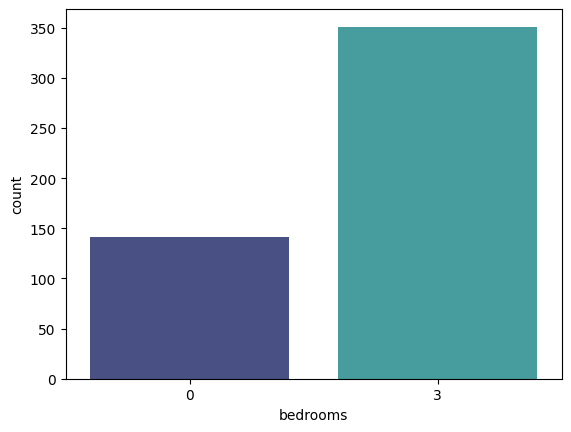

In [128]:
#Visualize the options in seaborn countplot.
sns.countplot(df, x = 'bedrooms', palette = 'mako');

## Observations on Count Plot of Bedrooms

- **Prevalence of Three-Bedroom Properties**:  
  There are more than twice as many three-bedroom properties in the dataset compared to studio apartments.

- **Dataset Composition**:  
  Approximately 75% of the dataset consists of three-bedroom properties, indicating a strong preference or availability for this type of accommodation.


# Feature 03 - Added On

1. **No Charts for DateTime Analysis**:  
   Since the "Added On" feature is a datetime field, we will not include any charts for this analysis. Instead, we will focus on its implications for the dataset and any potential trends related to the timing of property listings.


#Feature 04 - Type

In [129]:
#checking the type of transactions in the dataset.
df.type.value_counts()

type
buy    492
Name: count, dtype: int64

Observations on the Type Feature:
* All properties listed are for sale and not rental

# Feature 05 - Property Type

In this section, we will explore the **Property Type** feature to understand the diversity of properties included in the dataset:

1. **Distribution Analysis**:  
   Examine the distribution of different property types (e.g., apartments, villas, etc.) to understand the variety present in the dataset.

2. **Central Tendency**:  
   Calculate key statistics related to property types to identify which types are most common.

3. **Relationship with Price**:  
   Investigate how different property types correlate with property prices, as certain types may command higher prices.

4. **Impact on Analysis**:  
   Discuss how the uniformity of property types (if applicable) might affect the overall analysis and insights.

5. **Visualization**:  
   Consider using bar charts or pie charts to visually represent the distribution of property types within the dataset.


In [130]:
#checking the type of properties in the dataset.
df.propertyType.value_counts()

propertyType
apartment    492
Name: count, dtype: int64

Observations on Property Type:
* All listed properties are apartments.

#Feature 06 - Price


In [131]:
#Changing the display options in the charts to remove scientific notation for improved readability.
pd.options.display.float_format = '{:.2f}'.format

In [132]:
#Getting a statistical summary of the price column.
df.price.describe()

count        492.00
mean     2166491.44
std      2126997.71
min       233000.00
25%       952963.75
50%      1499000.00
75%      2434250.00
max     14500000.00
Name: price, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


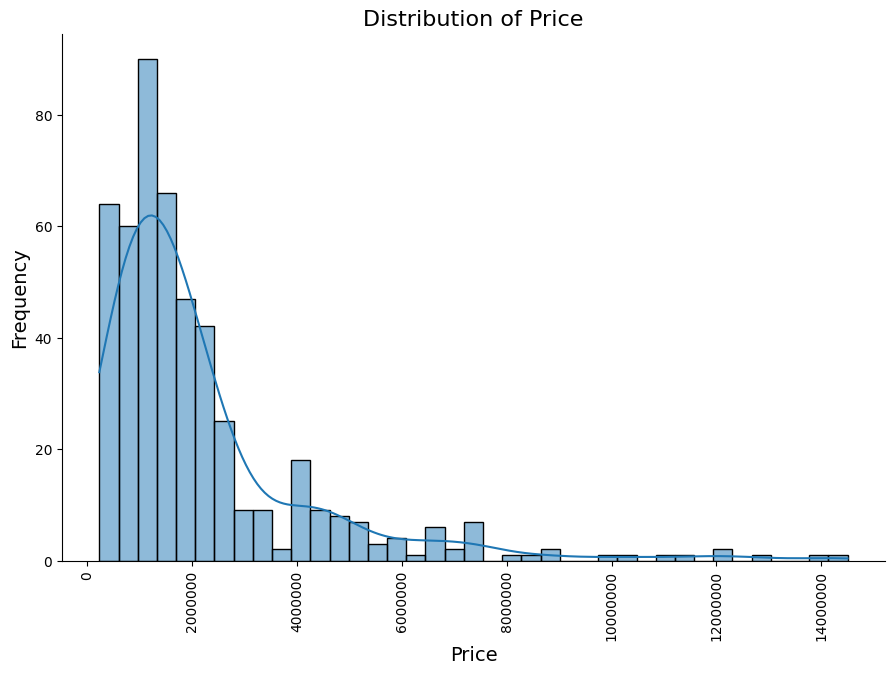

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the distribution of the 'price' column with KDE (Kernel Density Estimate)
sns.displot(df, x='price', kde=True, height=6, aspect=1.5)

# Formatting the x-axis labels
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='x')  # Ensure large numbers on the x-axis are displayed plainly, not in scientific notation

# Add title and labels for better clarity
plt.title('Distribution of Price', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()


## Observations on the Price Feature

- **Average Price**:  
  The average price in this dataset is approximately 2.17 million AED.

- **Skewed Distribution**:  
  The price distribution is skewed, likely due to the significant difference in pricing between studio apartments and three-bedroom properties.

- **Impact of Additional Property Types**:  
  The inclusion of one- and two-bedroom apartments in the dataset would likely provide a clearer picture of price distributions.

- **Price Range**:  
  The cheapest apartment in this dataset is priced at 233,000 AED, while the most expensive property is valued at 14 million AED.

- **Data Spread**:  
  There is a considerable spread of data above the 75th quartile, indicating a range of high-priced properties.

- **Right-Skewed Data**:  
  The right skew in the data reflects the presence of high-end luxury apartments, contributing to the overall price dynamics in the dataset.


# Feature 07 - Sub Development

In this section, we will analyze the **Sub Development** feature to understand its implications for the dataset and the property market:

1. **Definition and Context**:  
   Define what is meant by "Sub Development" and how it relates to the properties listed in the dataset.

2. **Distribution Analysis**:  
   Examine the distribution of properties across different sub-developments to identify popular areas and any potential trends.

3. **Relationship with Price**:  
   Investigate how sub-developments correlate with property prices, as certain developments may offer higher-end properties or unique amenities.

4. **Impact on Analysis**:  
   Discuss how the distribution and characteristics of sub-developments might affect overall property values and market trends.

5. **Visualization**:  
   Consider using bar charts or maps to visually represent the concentration of properties across various sub-developments, highlighting any significant findings.


In [134]:
#checking the number of sub developments in the dataframe
df.sub_development.value_counts()

sub_development
Reeman Living                26
Reeman Living II             15
Diva                         12
Binghatti Crest              11
Radiant Boulevard            11
                             ..
Palace Residences             1
Palace Residences - North     1
Meera                         1
The Palm Tower                1
Ansam 1                       1
Name: count, Length: 249, dtype: int64

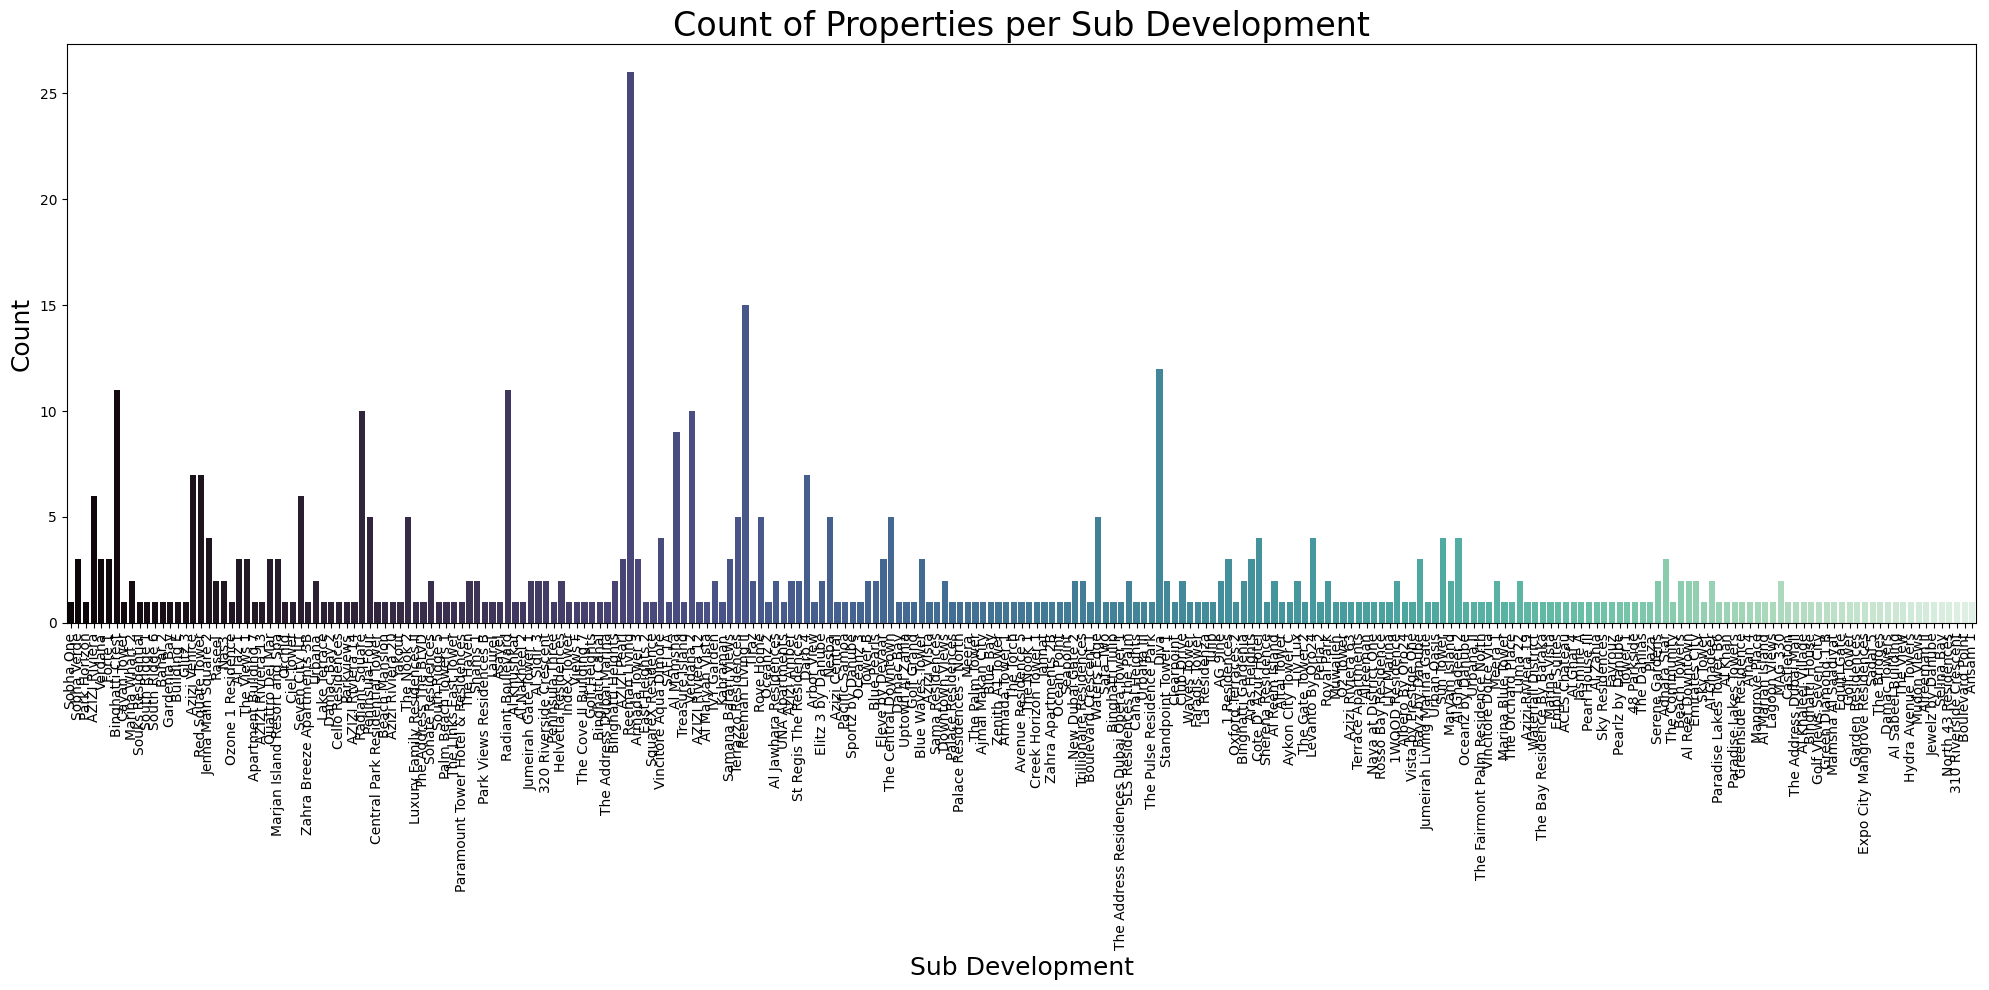

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better visibility
plt.figure(figsize=(20, 10))

# Create a count plot for 'sub_development'
sns.countplot(data=df, x='sub_development', palette='mako')

# Rotate x-ticks for better readability
plt.xticks(rotation=90)

# Add title and labels for clarity
plt.title('Count of Properties per Sub Development', fontsize=24)
plt.xlabel('Sub Development', fontsize=18)
plt.ylabel('Count', fontsize=18)

# Display the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()


Observations on Sub Development Location of Properties:
* The top frequency of properties are listed in Reeman Living
* Properties with more than 10 listings are in the following locations:
 * Binghatti Crest
 * Radiant Square
 * Radiant Boulevard
 * Reeman Living
 * Reeman Living II
 * Diva
* Properties with more than 5 Listings withing the Building are the following:
 * Azizi Riviera
 * Azizi Venice
 * Red Square Tower
 * Central Park Residential Tower
 * The Nook 2
 * Terrazo Residences
 * Tiraz
 * Darb 4
 * Nesba
 * The Central Downtown
 * Water's Edge





#Feature 08 - Main Development

In [136]:
#Checking the main development types.
df.main_development.value_counts()

main_development
Jumeirah Village Circle    44
Al Shamkha                 43
City Of Lights             22
Yas Island                 20
Arjan                      14
                           ..
Dubai Studio City           1
Pacific                     1
Al Maryah Island            1
Emirates Hills 2            1
Ansam                       1
Name: count, Length: 128, dtype: int64

#Feature 09 - Area

In [137]:
#Create a list of different types of areas where developments are
df.area.value_counts()

area
                               299
Al Reem Island                  35
Downtown                        12
Meydan                          11
Muwaileh                        11
Business Bay                    11
Jumeirah Lake Towers             7
Greens                           7
Mohammed Bin Rashid City         6
Jumeirah Beach Residence         6
Town Square                      6
Wasl Gate                        6
South ( World Central)           5
The World Islands                4
Yas Island                       4
Al Kifaf                         4
Al Marjan Island                 4
Creek Harbour (The Lagoons)      3
Marina                           3
Harbour                          3
Palm Jumeirah                    3
Mina Al Arab                     3
Aljada                           2
Production City (IMPZ)           2
Al Furjan                        2
Al Hamriyah                      2
Maritime City                    2
City Walk                        2
Umm Suqeim     

Observations on Area:
* Almost half of the dataset does not have a location other than the city that it is in (Dubai, Abu Dhabi, etc.)
* Some time needs to be taken to get the geodata for each building name
* most of the buildings are clustered into specific areas within Dubai and Abu Dhabi.


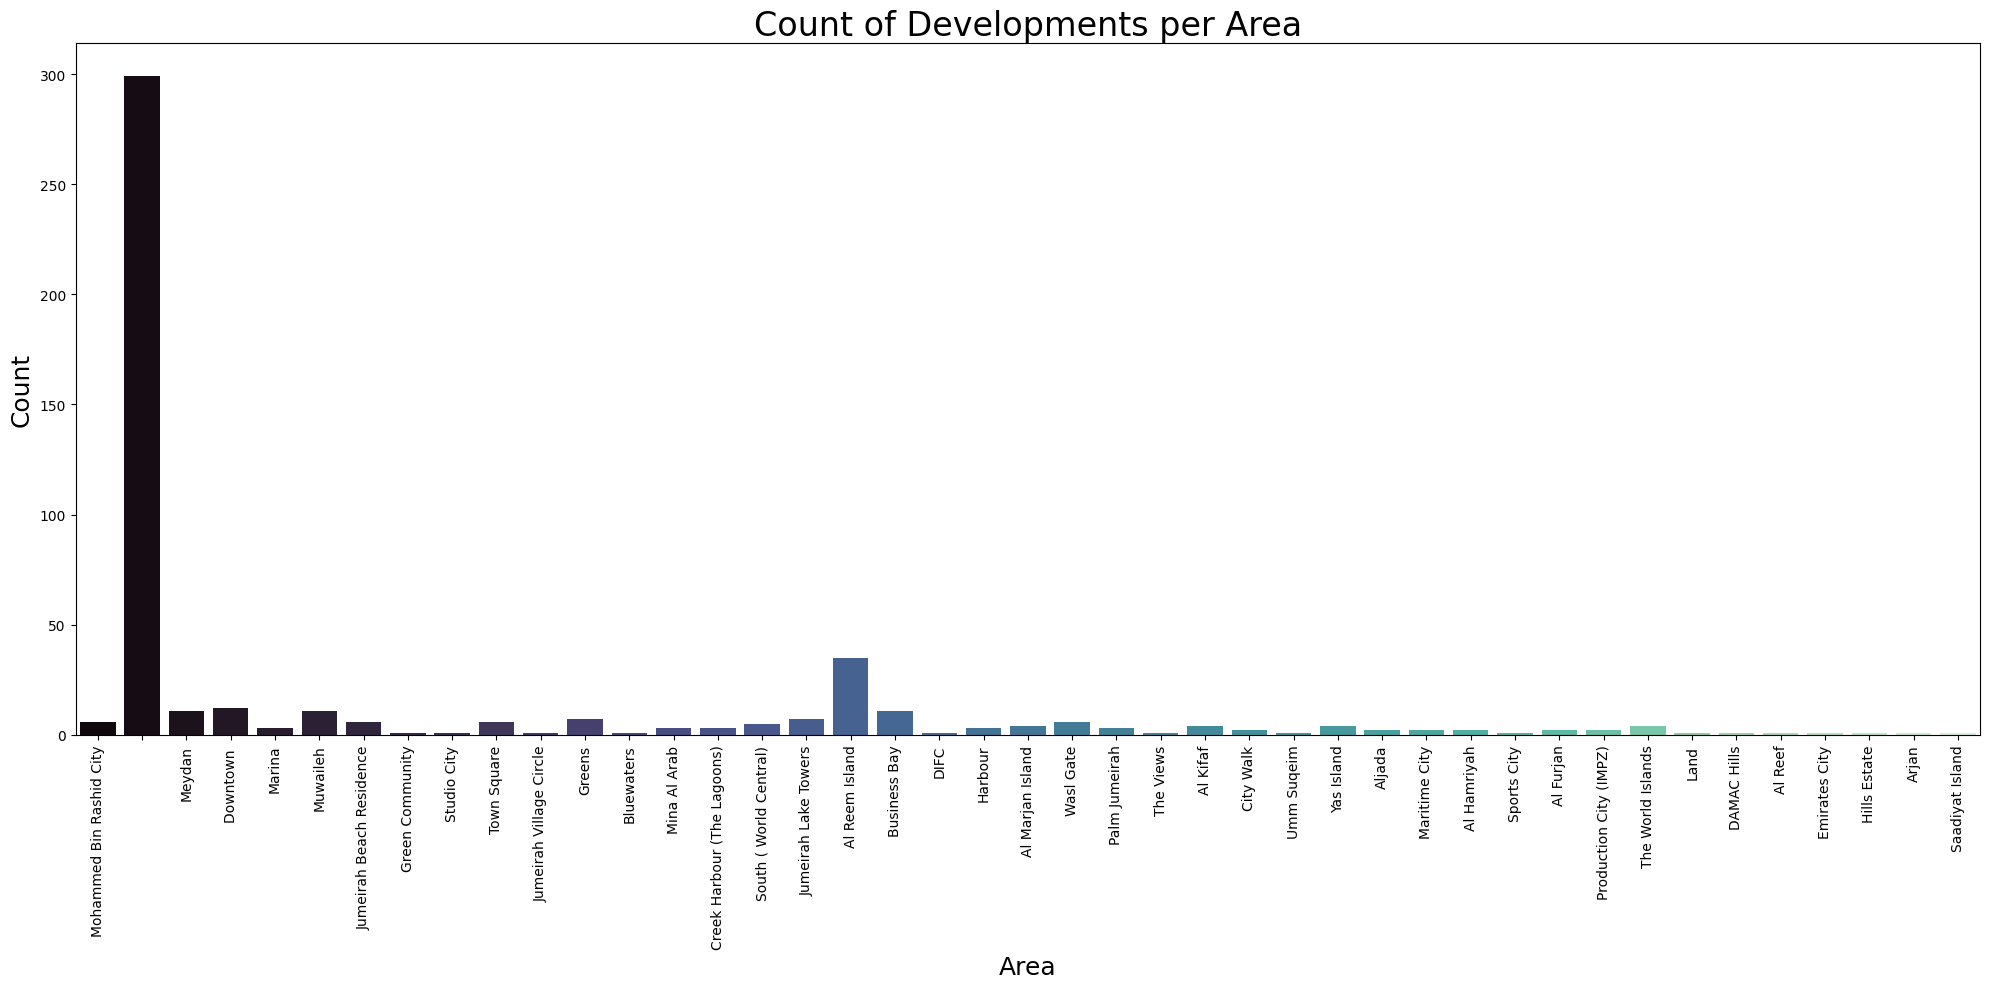

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better visibility
plt.figure(figsize=(20, 10))

# Create a count plot for 'area'
sns.countplot(data=df, x='area', palette='mako')

# Rotate x-ticks for better readability
plt.xticks(rotation=90)

# Add title and labels for clarity
plt.title('Count of Developments per Area', fontsize=24)
plt.xlabel('Area', fontsize=18)
plt.ylabel('Count', fontsize=18)

# Display the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()


#Feature 10 - City

In [139]:
#check how many properties per city.
df.city.value_counts()

city
Dubai             307
Abu Dhabi         118
Sharjah            38
Ras Al Khaimah     13
Ajman               4
Name: count, dtype: int64

Observations on the City:
* Most properties are in Dubai, which is no shock considering most of the properties in Dubai are apartments.
* Abu Dhabi has large apartment areas like reem island which are comparable to the Dubai style developments.
* Sharjah the 3rd, which is similarl and only a few in the Northern Emirates.

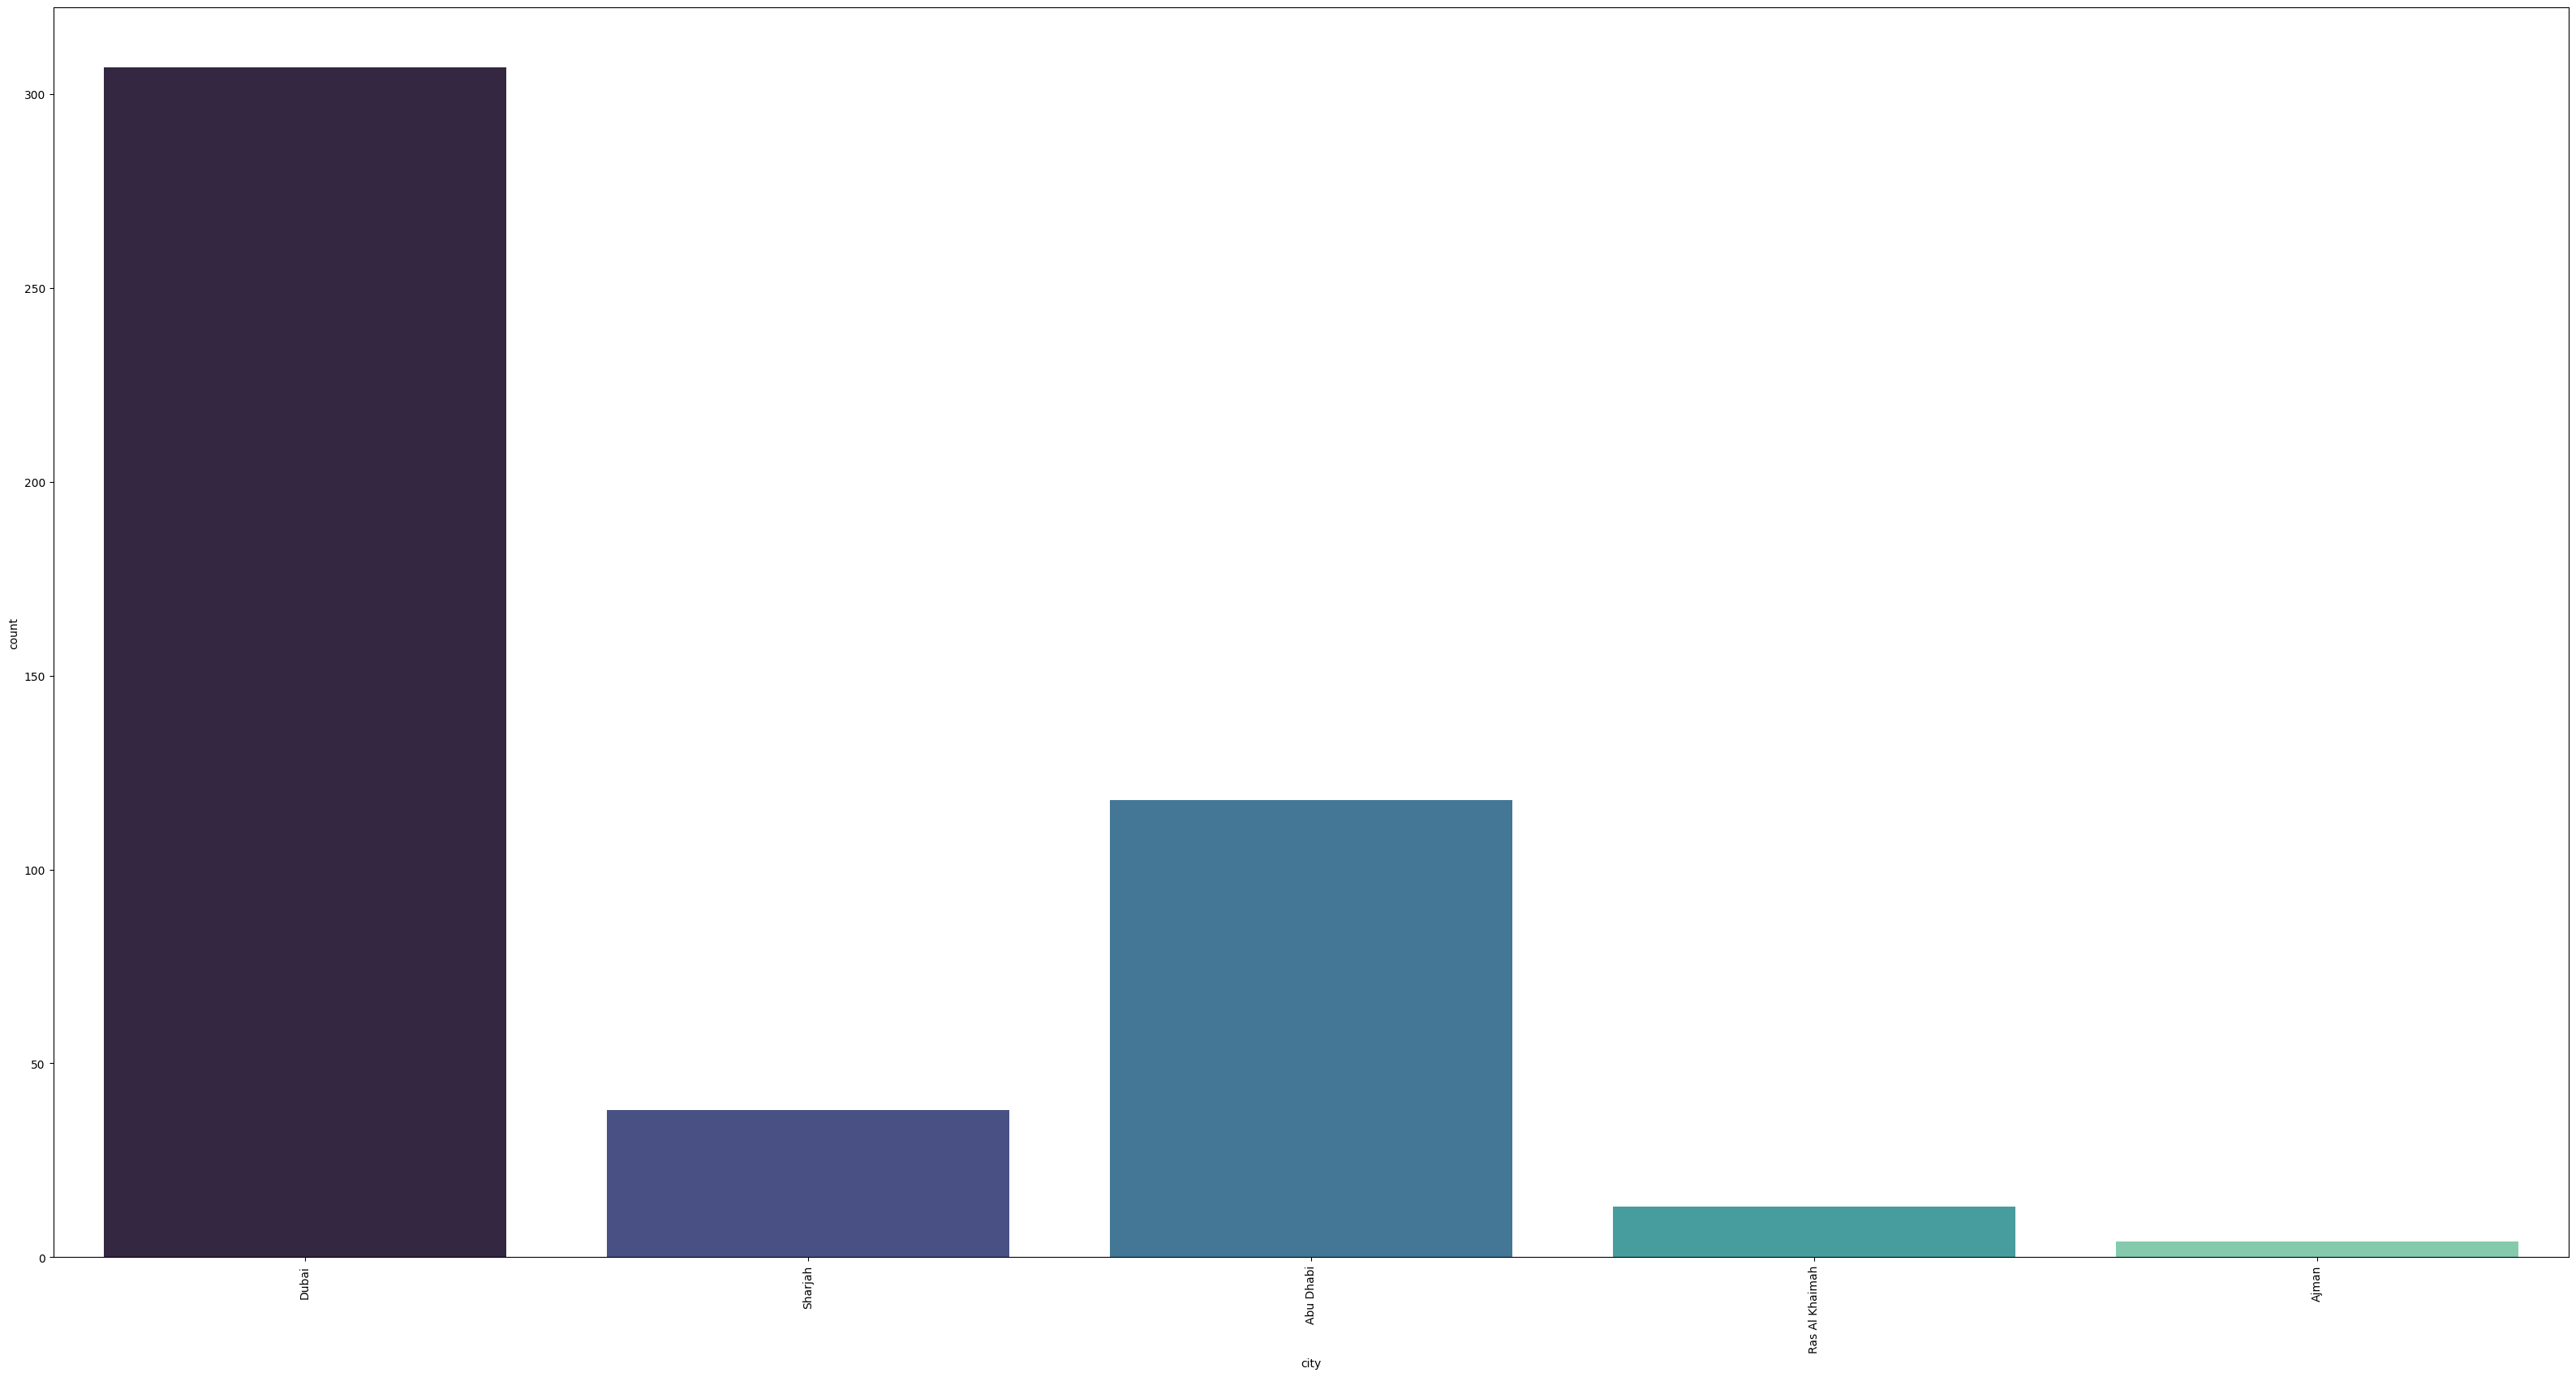

In [140]:
#visualize the numbers of properties per city in a countplot.
plt.figure(figsize=(40,20))
sns.countplot(df, x = 'city', palette = 'mako')
plt.xticks(rotation=90);

#Feature 11 - Month Added

In [141]:
# Map the numeric month representation to string labels
df['month_added'] = df['month_added'].map({
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
})



In [142]:
#check how many properties were added in each month.
df.month_added.value_counts()

Series([], Name: count, dtype: int64)

In [143]:
print(df['month_added'].isnull().sum())
print(df['month_added'].unique())
print(df.shape)
print(df['month_added'].dtype)
df['month_added'].fillna('Unknown', inplace=True)  # Replace NaNs with 'Unknown'


492
[nan]
(492, 15)
object


/tmp/ipykernel_33/2314914474.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['month_added'].fillna('Unknown', inplace=True)  # Replace NaNs with 'Unknown'


Observations on Month Added:
* About half of the entries were added in the first quarter of the year
* There were almost no entries in Spring time, strangely.
* Summer is expected to be slow as the heat is high and people are out of the country.
* Fall and Winter the dataset picks up, but this may be due to the time searched on the website from where the data was scraped.

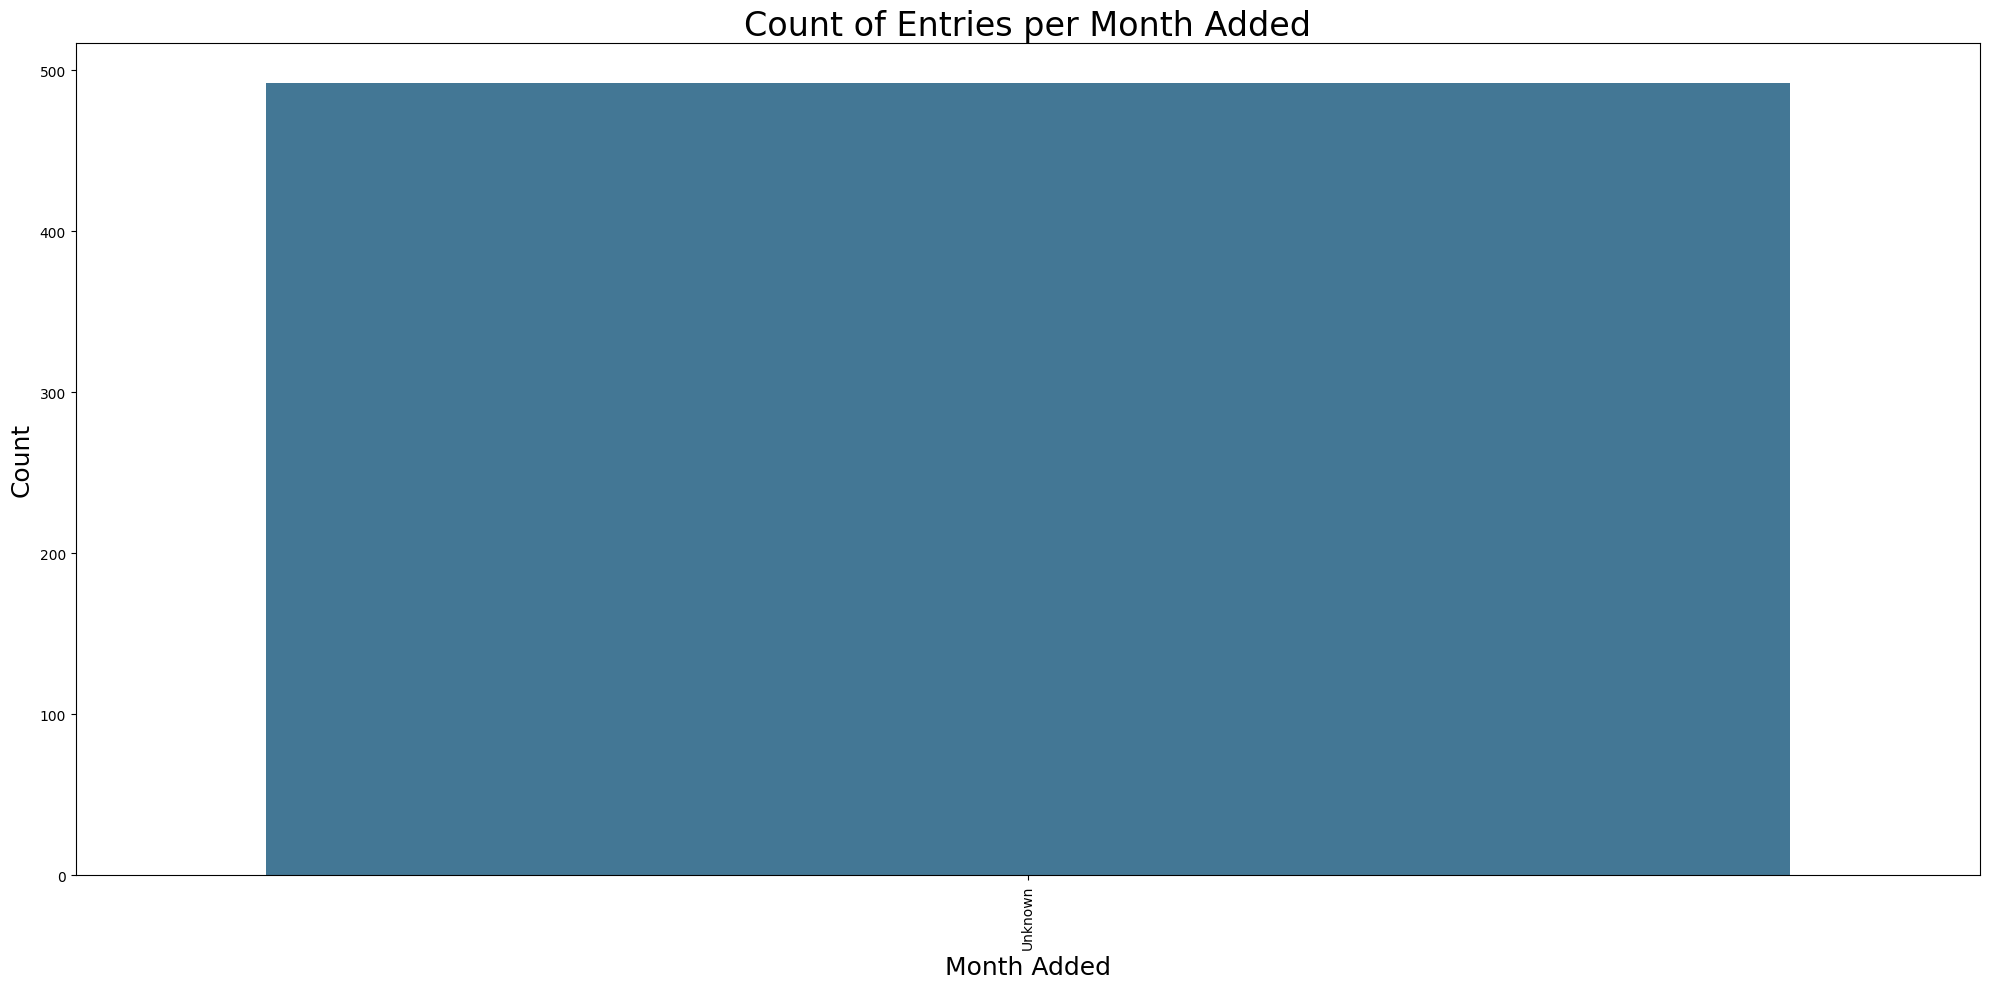

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with NaN values in the month_added column
df = df.dropna(subset=['month_added'])

# Visualize the number of counts per month
plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='month_added', palette='mako')

# Rotate x-ticks for better readability
plt.xticks(rotation=90)

# Add title and labels for clarity
plt.title('Count of Entries per Month Added', fontsize=24)
plt.xlabel('Month Added', fontsize=18)
plt.ylabel('Count', fontsize=18)

# Display the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()


#Feature 12: View

In [145]:
df.View.value_counts()

View
1.00    23
Name: count, dtype: int64

Observations on View:
* Most of the apartments in this list do not have a view listed.
* Only about 25% of the apartments have a view, and this may be due to many of the listed apartments being in Abu Dhabi on reem island where there is no landmark view.

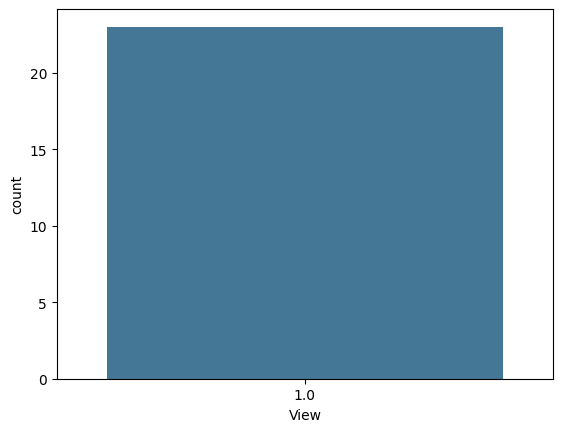

In [146]:
sns.countplot(df, x ='View', palette = 'mako');

#Feature 13: Furnished

In [147]:
df.furnished.value_counts()

furnished
False    431
True      61
Name: count, dtype: int64

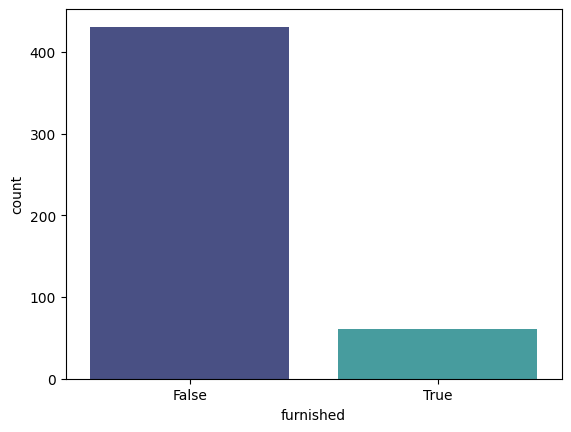

In [148]:
sns.countplot(df, x ='furnished', palette = 'mako');

Observations on Furnished Apartments:
* less than 1% of the apartments are furnished

#Feature 14: Pool

In [149]:
df.pool.value_counts()

pool
False    459
True      33
Name: count, dtype: int64

Observations on Pool:
* Many apartments are listed as not having a pool, however I believe this is referring to a private pool as most if not all buildings in the UAE in Dubai and Abu Dhabi have a pool and facilities within the building.

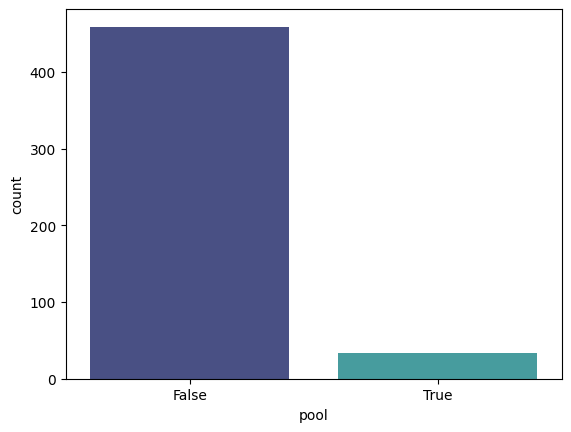

In [150]:
sns.countplot(df, x ='pool', palette = 'mako');

#Multi-variate EDA:

In [151]:
df.groupby('bedrooms')['price'].mean()

bedrooms
0    783539.62
3   2722036.19
Name: price, dtype: float64

Observations on Bedrooms & Price of Apartments:

* The averager price for a studio is about 783,000 AED
* The average price for a 3 bedroom apartment is about 2.7 million

In [152]:
plt.figure(figsize = (15, 7))
df.groupby(['area','bedrooms'])['price'].mean().sort_values(ascending = False).head(25)

area                         bedrooms
Bluewaters                   3          14500000.00
Saadiyat Island              3          11000000.00
Palm Jumeirah                3           9501133.33
Umm Suqeim                   3           7500000.00
City Walk                    3           6700000.00
Business Bay                 3           6572500.00
Jumeirah Beach Residence     3           6133333.17
Harbour                      3           5948296.00
Downtown                     3           5367096.17
DIFC                         3           4500000.00
The Views                    3           4350000.00
Creek Harbour (The Lagoons)  3           4179066.67
Mohammed Bin Rashid City     3           4082118.33
Mina Al Arab                 3           4000000.00
Al Kifaf                     3           3866763.25
Yas Island                   3           3727020.67
Hills Estate                 3           3306888.00
DAMAC Hills                  3           2954000.00
Green Community           

<Figure size 1500x700 with 0 Axes>

Observations on Sub Development Average Prices:

* The above list is the top 25th highest average prices of apartments and their bedroom counts
* Blue Waters area is the most expensive area
* Saadiyat Island is the second most expensive area
* The least expensive 25th area is Al Marjan Island
* It appears that Dubai Marina has the most expensive Studio apartments


Observations on the Minimum Price for the top 25 Areas:
* Al marjan is still the cheapest of the top 25 areas
* Bluewaters and Saadiyat minimum is the same as the average, which means most likley there is only 1 apartment listed in that area.


In [153]:
df.groupby(['area','bedrooms'])['price'].std().sort_values(ascending = False).head(25)

area                         bedrooms
Palm Jumeirah                3          4636941.22
Business Bay                 3          3608465.25
Jumeirah Beach Residence     3          2742748.26
                             3          1913217.12
Mohammed Bin Rashid City     3          1416421.56
Downtown                     3          1396576.13
Yas Island                   3          1348719.49
City Walk                    3          1131370.85
Harbour                      3           978580.97
Creek Harbour (The Lagoons)  3           930313.29
Meydan                       3           758287.54
Al Furjan                    3           596091.02
Al Kifaf                     3           573009.01
                             0           544491.17
Al Marjan Island             3           404000.93
Al Reem Island               3           399344.80
Jumeirah Lake Towers         3           356737.87
Wasl Gate                    3           332791.23
Town Square                  3           249

Observations on Area Standard Deviation of Price:
* The Palm Jumeirah has the largest variation (Standard deviation) which means the price ranges are more spread from the mean than the other areas.
* Dubai South has the lowest of the the 25 areas, which could indicate that the variation in prices in this area is minimal and we can expect the average prices to be near to the real selling price.
*Prices in Abu Dhabi seem to be closer to the mean for both 3 bedrooms and studios compared to Dubai.

In [154]:
df.groupby(['area','bedrooms'])['price'].describe()

count        mean        std  \
area                        bedrooms                                 
                            0        112.00   743071.66  544491.17   
                            3        187.00  2385240.22 1913217.12   
Al Furjan                   3          2.00  2121500.00  596091.02   
Al Hamriyah                 0          2.00   445000.00   63639.61   
Al Kifaf                    3          4.00  3866763.25  573009.01   
Al Marjan Island            0          1.00   530000.00        NaN   
                            3          3.00  2133500.00  404000.93   
Al Reef                     3          1.00  1200000.00        NaN   
Al Reem Island              0          3.00   754266.67  136918.27   
                            3         32.00  1487328.09  399344.80   
Aljada                      0          2.00   490000.00       0.00   
Arjan                       3          1.00  1087000.00        NaN   
Bluewaters                  3          1.00 14500000.00        NaN   
Business Bay                0          3.00  1185000.00  106887.79   
                            3          8.00  6572500.00 3608465.25   
City Walk                   3          2.00  6700000.00 1131370.85   
Creek Harbour (The Lagoons) 3          3.00  4179066.67  930313.29   
DAMAC Hills                 3          1.00  2954000.00        NaN   
DIFC                        3          1.00  4500000.00        NaN   
Downtown                    3         12.00  5367096.17 1396576.13   
Emirates City               3          1.00   280000.00        NaN   
Green Community             3          1.00  2950000.00        NaN   
Greens                      3          7.00  2321428.57   90632.70   
Harbour                     3          3.00  5948296.00  978580.97   
Hills Estate                3          1.00  3306888.00        NaN   
Jumeirah Beach Residence    3          6.00  6133333.17 2742748.26   
Jumeirah Lake Towers        3          7.00  1785714.29  356737.87   
Jumeirah Village Circle     0          1.00   554000.00        NaN   
Land                        0          1.00   490000.00        NaN   
Marina                      0          1.00  2200000.00        NaN   
                            3          2.00  2025000.00  106066.02   
Maritime City               0          2.00  1080000.00  141421.36   
Meydan                      0          2.00   724500.00   34648.23   
                            3          9.00  2466666.67  758287.54   
Mina Al Arab                0          1.00   920000.00        NaN   
                            3          2.00  4000000.00       0.00   
Mohammed Bin Rashid City    3          6.00  4082118.33 1416421.56   
Muwaileh                    0          1.00   495000.00        NaN   
                            3         10.00  1475600.00   92915.97   
Palm Jumeirah               3          3.00  9501133.33 4636941.22   
Production City (IMPZ)      0          1.00   530000.00        NaN   
                            3          1.00  1918437.00        NaN   
Saadiyat Island             3          1.00 11000000.00        NaN   
South ( World Central)      3          5.00  1662000.00  168878.65   
Sports City                 3          1.00   899990.00        NaN   
Studio City                 3          1.00  1350000.00        NaN   
The Views                   3          1.00  4350000.00        NaN   
The World Islands           0          4.00  1787500.00   26299.56   
Town Square                 3          6.00  1648333.33  249833.28   
Umm Suqeim                  3          1.00  7500000.00        NaN   
Wasl Gate                   3          6.00  1675000.00  332791.23   
Yas Island                  0          1.00   850000.00        NaN   
                            3          3.00  3727020.67 1348719.49   

                                             min         25%         50%  \
area                        bedrooms                                       
                            0      

Observations on Statistical Summary of Area and Bedrooms:
* We can see that many of the entries in areas are single entries and for an improve statistical summary, we'd want to remove these single entries and then run the area analysis.
* however for the purposes of rudimentary analysis, we can see the area breakdown and the price deviation across each area.
* similarly, we would remove the city entries from this column and migrate them to the city column itself to further enhance the data purity.

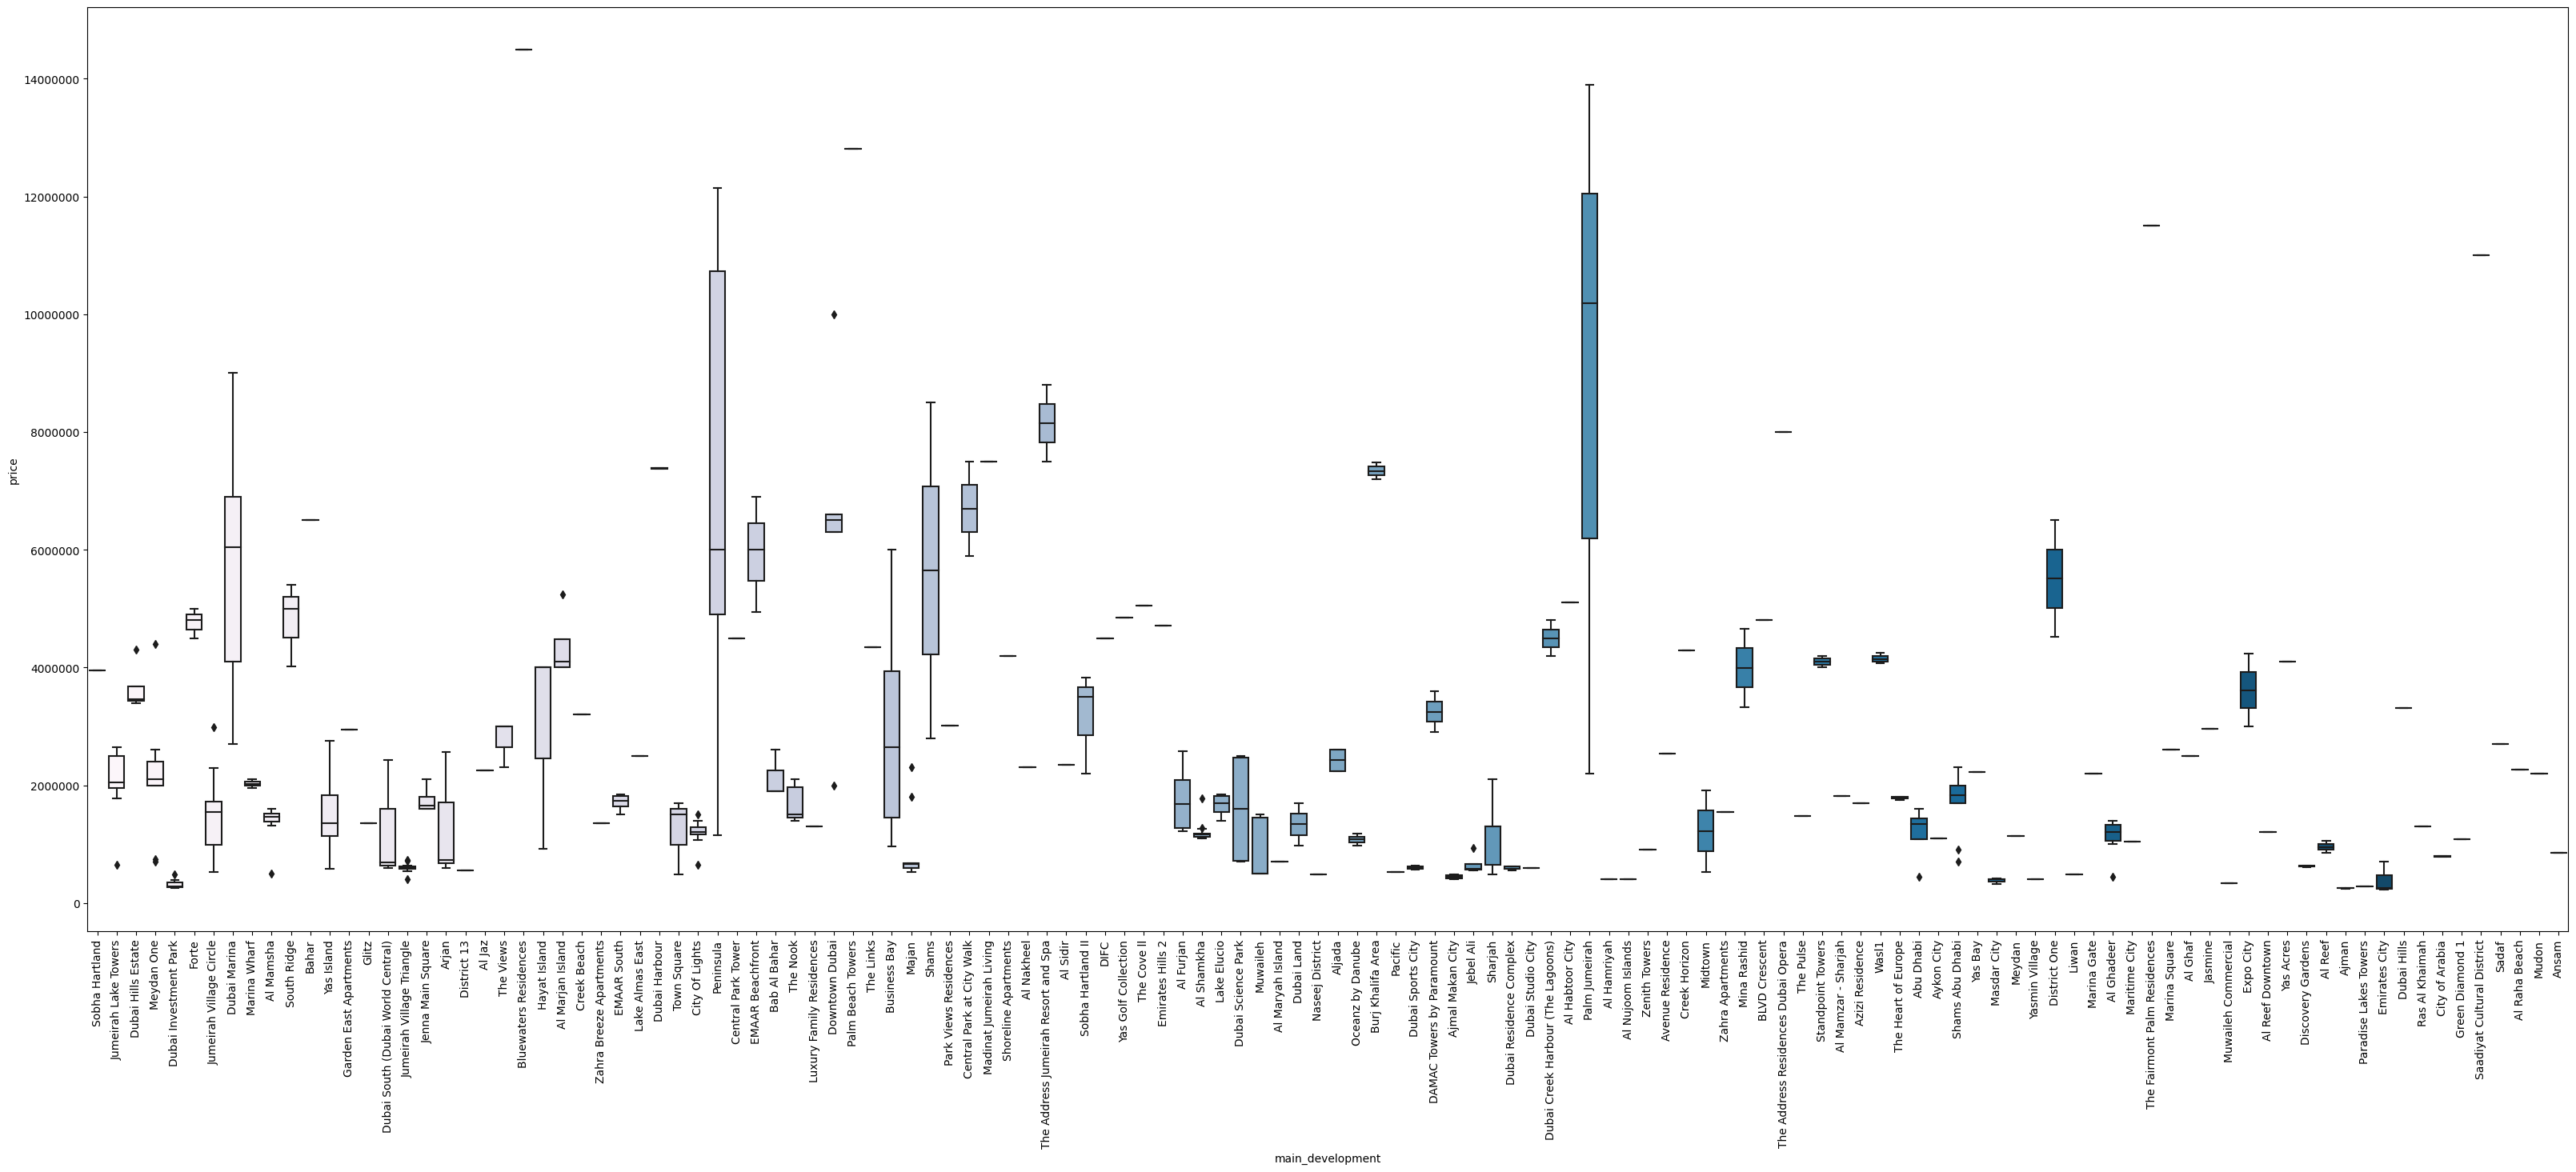

In [155]:
# Relationship between main development area and the price spread of properties within that main development.
plt.figure(figsize=(40,15))
sns.boxplot(x = "main_development", y = "price", data = df, palette = 'PuBu')
plt.xticks(rotation = 90)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Observations on Main Development Price Range:
* The largest spread of prices in a development is within:
 * Dubai Marina
 * Peninsula
 * Palm Jumeirah
* There are many properties around the mean price
* Most of the property spreads are small as there are not enough entries to evaluate IQR spread.


In [156]:
#Checking the number of counts of properties added each month
df.month_added.value_counts()

month_added
Unknown    492
Name: count, dtype: int64

Observations on Month Added:
* More than half the properties were added in the first quarter of the year
* Naturally, there is not much activity into the hotter months of the year
* We could surmise that many people are trying to sell or list their properties when the weather is nicer.

In [157]:
month=df.groupby(['month_added','bedrooms'])['price'].describe()
month.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'lightgreen', axis = 0)


Observations on Prices of Sales Listings by Month:

* The largest month uploads onto the data base was in Feb with 96 - 3 bedroom apartments entered onto the site.
* May had the least uploads with only 1 property put onto the website.
The highest average price listing for 3 bedrooms is in September.
* The highest average price listing for studios is in November.
* The lowest average price listing for a 3 bedroom is in July.
* The lowest average price listing for a studio is in August.
* The lowest standard deviation (spread) of prices for a 3 bedroom is in October.
* The lowest standard deviation (spread) of prices for a studio is in June with only 35,000 aed approximately between 3 apartments.
* The cheapest studio apartment listed was in December.
* The cheapest 3 bedroom was listed in May.
* The lowest median studio apartment fee was listed in August.
* the lowest 3 bedroom median was in July
* The highest median 3 bedroom apartments were listed in September.
* The most expensive 3 bedroom were listed in September.

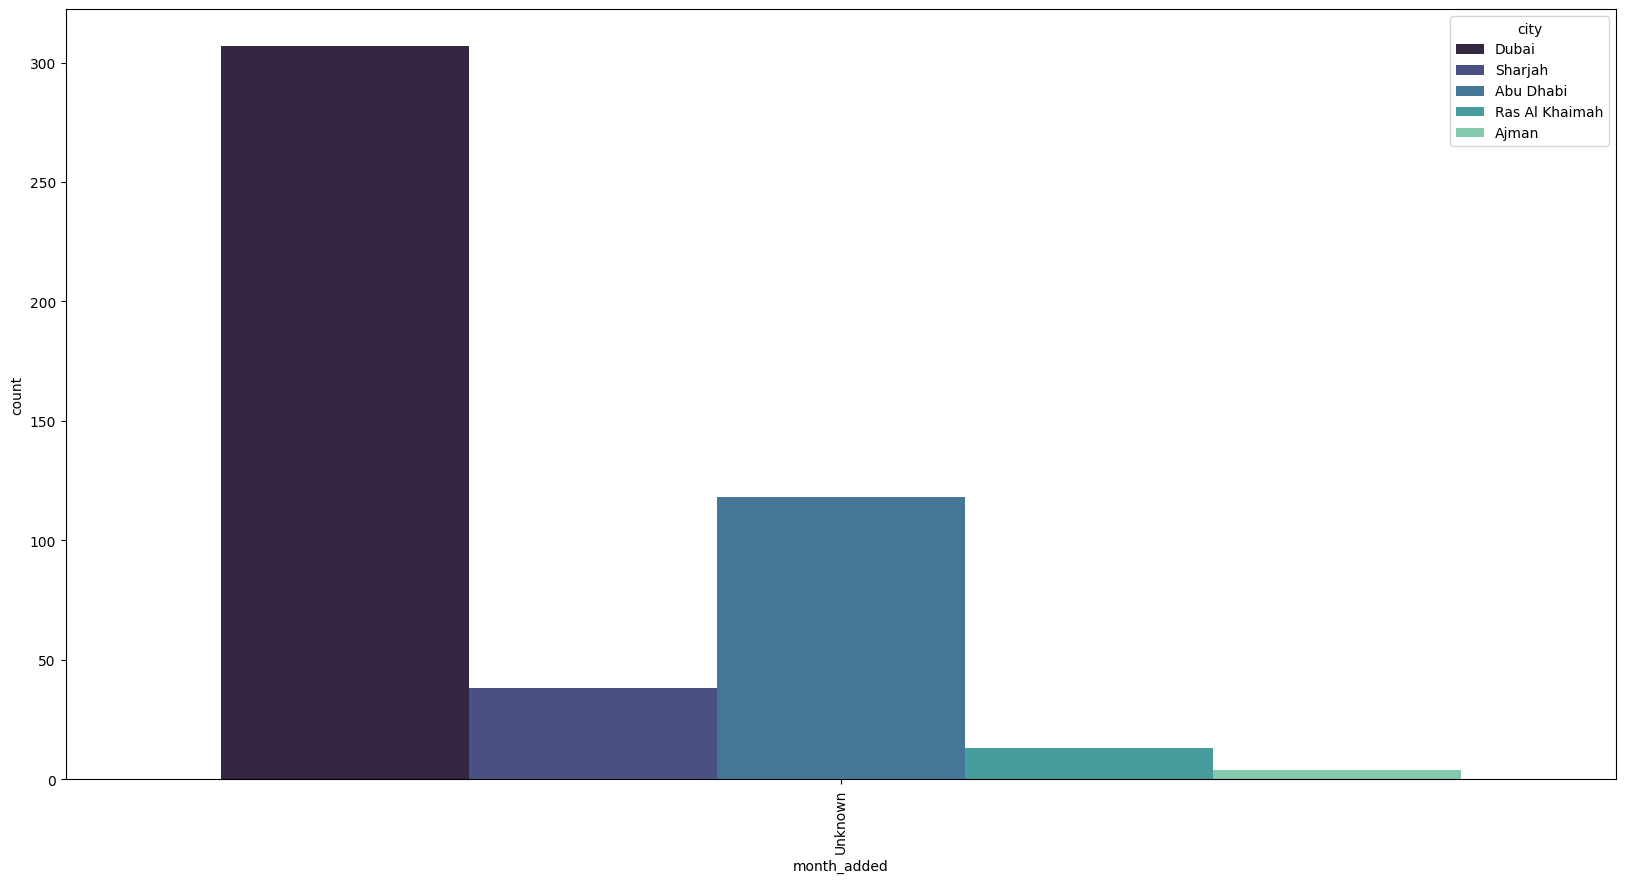

In [158]:
plt.figure(figsize=(20,10))
sns.countplot(df, x = 'month_added', hue = 'city', palette = 'mako')
plt.xticks(rotation=90);

Observations on the Market Movements by Month & City:

* Dubai has the highest volume activity in March and Februrary
* Sharjah has a its most active months in the first quarter and the last two months of the last quarter.
* Abu Dhabi also sees the most activities in the first quarter with another pick up in September and end of the year.  
* RAK & Ajman are pretty stable across the whole year - likely due to the limited amount of apartment type properties in those cities.

In [159]:
# Get most popular areas added to the database in February
df_feb= df[df['month_added'] == 'Feb']
df_feb['main_development'].value_counts()

Series([], Name: count, dtype: int64)

Observations on Main Development Activity in February:
* Jumeirah Village Circle, Business Bay and DIP have the most activity in February
* Shamkha, City of Lights (reem island) have the most for Abu Dhabi.

In [160]:
df_march = df[df['month_added'] =='Mar']
df_march['main_development'].value_counts()

Series([], Name: count, dtype: int64)

Observations on Main Development Activities in March (Second most populous month):

* Similar areas of activity are also active in March.
* The only difference is a pick up in activity in listings in JVT area of Dubai.

In [161]:
# Get apartments that cost more than 2 million
df_greater_than_2 = df[df['price'] > 2000000]

# Calculate the number of total orders where the cost is above 2 Million AED

print('The number of total Apartments above 2 million AED is:', df_greater_than_2.shape[0])

# Calculate percentage of such properties in the dataset
percentage = (df_greater_than_2.shape[0] / df.shape[0]) * 100

print("Percentage of apartments above 2 million AED:", round(percentage, 2), '%')

The number of total Apartments above 2 million AED is: 165
Percentage of apartments above 2 million AED: 33.54 %


Observations on Price Range Activities:

* There are 165/492 total properties above 2 million AED, which represents about 34% of the dataset and market activity.


In [162]:
# Get apartments that cost less than 500,000 AED
df_less_than_half = df[df['price'] < 500000]

# Calculate the number of total apartments where the cost is below 500,000 AED

print('The number of total Apartments below 500k is:', df_less_than_half.shape[0])

# Calculate percentage of such properties in the dataset.
percentage = (df_less_than_half.shape[0] / df.shape[0]) * 100

print("Percentage of apartments below 500k:", round(percentage, 2), '%')

The number of total Apartments below 500k is: 41
Percentage of apartments below 500k: 8.33 %


Observations on Lower End of Apartments:
* There are only 41 apartments which are less than 500,000 AED, which represents approximately 8% of the dataset.

In [163]:
# Calculate the number of total orders where the cost is between 500k and 2 million AED.
df_between_range1 = df[df['price'].between(500000, 2000000)]


print('The number of total Apartments between 500,000 and 2 million', df_between_range1.shape[0])

# Calculate percentage of properties within the dataset that are between the above range.
percentage = (df_between_range1.shape[0] / df.shape[0]) * 100

print("Percentage of apartments between 500k and 2 Million AED", round(percentage, 2), '%')

The number of total Apartments between 500,000 and 2 million 286
Percentage of apartments between 500k and 2 Million AED 58.13 %


Observations on the lower to mean Range of Properties:

* there are 286 apartments between the range of 500k and 2 million (approximately the mean of all properties in the dataset.

In [164]:
df.describe()

,bathrooms,bedrooms,rera,price,View
count,492.00,492.00,323.00,492.00,23.00
mean,2.00,2.14,15629275948.98,2166491.44,1.00
std,0.00,1.36,28430120259.52,2126997.71,0.00
min,2.00,0.00,8470901.00,233000.00,1.00
25%,2.00,0.00,818620865.50,952963.75,1.00
50%,2.00,3.00,1678337573.00,1499000.00,1.00
75%,2.00,3.00,7131427185.50,2434250.00,1.00
max,2.00,3.00,202202794105.00,14500000.00,1.00


In [165]:
# Calculate the number of total orders where the cost is between 2 million and 4 million.
df_between_range2 = df[df['price'].between(2000000, 4000000)]


print('The number of total Apartments between 2 Million & 4 Million', df_between_range2.shape[0])

# Calculate percentage of properties within the dataset that are between the above range.
percentage = (df_between_range2.shape[0] / df.shape[0]) * 100

print("Percentage of apartments between 2 Million & 4 Million", round(percentage, 2), '%')

The number of total Apartments between 2 Million & 4 Million 104
Percentage of apartments between 2 Million & 4 Million 21.14 %


Observations on Middle to High End Properties:
* There are 104 properties between the approximate mean and the high end (above 75% upper bound)
*This represents 21.14% of the properties listed in the dataset.

# Dataset Observations & Business Intelligence Related to the DataSet

## Comments on the Data Set

- **Data Quality**:  
  The dataset could be more comprehensive and was moderately messy, containing some errors that have been cleaned.

- **Natural Language Processing**:  
  A Natural Language module was useful in extracting keywords from the free text column to gain improved insights. However, the validity of these free text entries remains uncertain, as they may not accurately reflect the properties.

- **Temporal Relevance**:  
  The database appears to capture a specific time period. Regular monthly updates will enhance its usability for price prediction using a regression model.

- **Data Preparation**:  
  The model has been cleaned to prepare for data preprocessing stages just prior to base model building. Further users can preprocess the data to change data types, insert dummy variables, and extract additional insights regarding relationships between categorical features (e.g., view, furnished, luxury) and their impact on selling prices.

- **Price Transformation**:  
  The price column needs a logarithmic transformation to improve its predictive capabilities.

- **Property Types**:  
  The types of properties listed should expand beyond studios and three-bedroom apartments to achieve a more normal distribution of prices, facilitating a more robust predictive model.

- **Segregating the Dataset**:  
  It may be beneficial to separate the dataset into two distinct databases—one for studio apartments and another for three-bedroom apartments—to enhance price prediction accuracy.

- **RERA Column**:  
  The RERA column, which contains contract numbers, does not provide much useful information for price prediction and could be removed. It has been retained in this version for reference, allowing for potential data extraction from the RERA website.

- **Learning Experience**:  
  This dataset cleaning was a personal exercise to enhance data cleaning skills, and the dataset should be further expanded as desired, based on the cleaner version than the one originally uploaded.

- **Acknowledgments**:  
  Special thanks to the original poster for their hard work in web scraping this data into a usable format, enabling individuals like me to practice cleaning and extracting data to enrich the exploratory data analysis (EDA) section for the Kaggle thread.

## Business Observations Based on the Dataset

- **Active Markets**:  
  Dubai and Abu Dhabi show the most activity, with JVC, JVT, Reem Island, and Shamka identified as the most active areas.

- **Apartment Distribution**:  
  About 75% of the dataset comprises three-bedroom apartments, which skews the mean prices higher.

- **High-Frequency Buildings**:  
  Real estate professionals should focus on buildings with a higher frequency of listings, including:
  - Binghatti Crest
  - Radiant Square
  - Radiant Boulevard
  - Reeman Living
  - Reeman Living II
  - Diva

- **Properties with Multiple Listings**:  
  Properties with more than five listings within the building include:
  - Azizi Riviera
  - Azizi Venice
  - Red Square Tower
  - Central Park Residential Tower
  - The Nook 2
  - Terrazo Residences
  - Tiraz
  - Darb 4
  - Nesba
  - The Central Downtown
  - Water's Edge

- **Sales Efficiency**:  
  Focusing on the main areas with high listing frequencies will optimize sales without the need for excessive travel across the city. Concentrating on key areas with abundant listings will maximize the timeframe and expected sales outcomes while minimizing operational costs for real estate agents.

- **Major Property Locations**:  
  Important property locations to focus on include:
  - Dubai Investment Park
  - Yas Island
  - City of Lights
  - Business Bay
  - Aljada
  - Shams Abu Dhabi
  - Al Ghadeer

- **Seasonal Trends**:  
  Most sales activity occurs in the first quarter of the year, with minimal new listings during the hotter months. This trend suggests a correlation between the real estate cycle and weather conditions, with increased listings during more favorable weather.

- **Buying Opportunities**:  
  Buyers looking for deals should consider the summer months, as the lowest-priced properties are typically listed during this time, potentially indicating sellers' desperation to sell when school semesters are inactive.

- **View Preferences**:  
  Many properties are listed with a 'view' extracted from the free text column, suggesting that buyers are inclined towards properties offering views of landmarks or water.

- **High-Value Areas**:  
  The most expensive properties are often located in areas with views of both landmarks and water, such as Bluewaters, Saadiyat Island, Palm Jumeirah, and Umm Suqeim. Agents focusing on these properties could significantly increase their commissions.

- **Price Variability**:  
  The largest price variations are observed in the Palm Jumeirah area, indicating a wide range of both value apartments and luxury options. Further investigation is needed to assess the pricing of luxury properties compared to regular apartments.

- **Price Stability**:  
  Dubai South shows the least price variation, suggesting that the market is well-informed about property values or that offered apartments are uniform with minimal negotiation room. Similarly, prices in Abu Dhabi appear more stable, exhibiting lower standard deviations across properties within specific areas.

- **Highest Price Spread Locations**:  
  The largest spread of prices occurs within:
  - Dubai Marina
  - Peninsula
  - Palm Jumeirah

- **Affordable Properties**:  
  Approximately 34% of the dataset contains properties priced below 2 million AED, with only 8% classified as 'cheaper.' About 58% of the dataset falls between 500k and 2 million AED, indicating that competition is most intense in this range.

- **Optimal Price Band**:  
  Real estate agents should concentrate on properties priced between 2 and 4 million AED, as this segment offers the most favorable return on investment concerning time spent and commission potential. This price band includes 104 properties, representing 21% of the dataset.

- **Sales Strategy Development**:  
  Developing a focused sales strategy arou# Dataset Observations & Business Intelligence Related to the DataSet

## Comments on the Data Set

- **Data Quality**:  
  The dataset could be more comprehensive and was moderately messy, containing some errors that have been cleaned.

- **Natural Language Processing**:  
  A Natural Language module was useful in extracting keywords from the free text column to gain improved insights. However, the validity of these free text entries remains uncertain, as they may not accurately reflect the properties.

- **Temporal Relevance**:  
  The database appears to capture a specific time period. Regular monthly updates will enhance its usability for price prediction using a regression model.

- **Data Preparation**:  
  The model has been cleaned to prepare for data preprocessing stages just prior to base model building. Further users can preprocess the data to change data types, insert dummy variables, and extract additional insights regarding relationships between categorical features (e.g., view, furnished, luxury) and their impact on selling prices.

- **Price Transformation**:  
  The price column needs a logarithmic transformation to improve its predictive capabilities.

- **Property Types**:  
  The types of properties listed should expand beyond studios and three-bedroom apartments to achieve a more normal distribution of prices, facilitating a more robust predictive model.

- **Segregating the Dataset**:  
  It may be beneficial to separate the dataset into two distinct databases—one for studio apartments and another for three-bedroom apartments—to enhance price prediction accuracy.

- **RERA Column**:  
  The RERA column, which contains contract numbers, does not provide much useful information for price prediction and could be removed. It has been retained in this version for reference, allowing for potential data extraction from the RERA website.

- **Learning Experience**:  
  This dataset cleaning was a personal exercise to enhance data cleaning skills, and the dataset should be further expanded as desired, based on the cleaner version than the one originally uploaded.

- **Acknowledgments**:  
  Special thanks to the original poster for their hard work in web scraping this data into a usable format, enabling individuals like me to practice cleaning and extracting data to enrich the exploratory data analysis (EDA) section for the Kaggle thread.

## Business Observations Based on the Dataset

- **Active Markets**:  
  Dubai and Abu Dhabi show the most activity, with JVC, JVT, Reem Island, and Shamka identified as the most active areas.

- **Apartment Distribution**:  
  About 75% of the dataset comprises three-bedroom apartments, which skews the mean prices higher.

- **High-Frequency Buildings**:  
  Real estate professionals should focus on buildings with a higher frequency of listings, including:
  - Binghatti Crest
  - Radiant Square
  - Radiant Boulevard
  - Reeman Living
  - Reeman Living II
  - Diva

- **Properties with Multiple Listings**:  
  Properties with more than five listings within the building include:
  - Azizi Riviera
  - Azizi Venice
  - Red Square Tower
  - Central Park Residential Tower
  - The Nook 2
  - Terrazo Residences
  - Tiraz
  - Darb 4
  - Nesba
  - The Central Downtown
  - Water's Edge

- **Sales Efficiency**:  
  Focusing on the main areas with high listing frequencies will optimize sales without the need for excessive travel across the city. Concentrating on key areas with abundant listings will maximize the timeframe and expected sales outcomes while minimizing operational costs for real estate agents.

- **Major Property Locations**:  
  Important property locations to focus on include:
  - Dubai Investment Park
  - Yas Island
  - City of Lights
  - Business Bay
  - Aljada
  - Shams Abu Dhabi
  - Al Ghadeer

- **Seasonal Trends**:  
  Most sales activity occurs in the first quarter of the year, with minimal new listings during the hotter months. This trend suggests a correlation between the real estate cycle and weather conditions, with increased listings during more favorable weather.

- **Buying Opportunities**:  
  Buyers looking for deals should consider the summer months, as the lowest-priced properties are typically listed during this time, potentially indicating sellers' desperation to sell when school semesters are inactive.

- **View Preferences**:  
  Many properties are listed with a 'view' extracted from the free text column, suggesting that buyers are inclined towards properties offering views of landmarks or water.

- **High-Value Areas**:  
  The most expensive properties are often located in areas with views of both landmarks and water, such as Bluewaters, Saadiyat Island, Palm Jumeirah, and Umm Suqeim. Agents focusing on these properties could significantly increase their commissions.

- **Price Variability**:  
  The largest price variations are observed in the Palm Jumeirah area, indicating a wide range of both value apartments and luxury options. Further investigation is needed to assess the pricing of luxury properties compared to regular apartments.

- **Price Stability**:  
  Dubai South shows the least price variation, suggesting that the market is well-informed about property values or that offered apartments are uniform with minimal negotiation room. Similarly, prices in Abu Dhabi appear more stable, exhibiting lower standard deviations across properties within specific areas.

- **Highest Price Spread Locations**:  
  The largest spread of prices occurs within:
  - Dubai Marina
  - Peninsula
  - Palm Jumeirah

- **Affordable Properties**:  
  Approximately 34% of the dataset contains properties priced below 2 million AED, with only 8% classified as 'cheaper.' About 58% of the dataset falls between 500k and 2 million AED, indicating that competition is most intense in this range.

- **Optimal Price Band**:  
  Real estate agents should concentrate on properties priced between 2 and 4 million AED, as this segment offers the most favorable return on investment concerning time spent and commission potential. This price band includes 104 properties, representing 21% of the dataset.

- **Sales Strategy Development**:  
  Developing a focused sales strategy around properties within this optimal price range can yield higher commissions compared to lower-end properties.
nd properties within this optimal price range can yield higher commissions compared to lower-end properties.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Average Train Accuracy: 1.000 ± 0.000
Average Test Accuracy: 1.000 ± 0.000


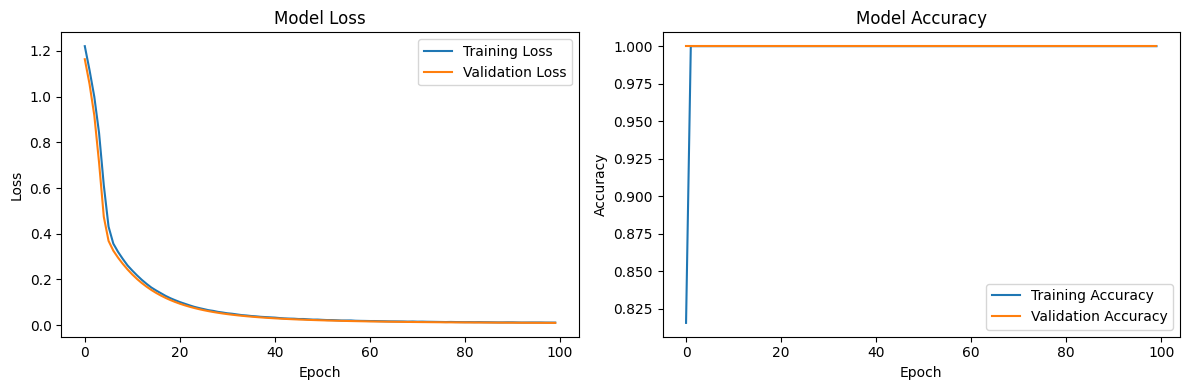

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

# Use 'price' as the target variable for prediction
data = df[['price']].values  

# Create binary target based on threshold (mean price)
threshold = np.mean(data)
y_binary = (data > threshold).astype(int).flatten()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create datasets function with added noise
def create_dataset(data, time_step=1, noise_level=0.01):
    X, y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        # Add small random noise to prevent perfect separation
        noise = np.random.normal(0, noise_level, a.shape)
        a = a + noise
        X.append(a)
        y.append((data[i + time_step, 0] > threshold).astype(int))
    return np.array(X), np.array(y)

# Set time step
time_step = 10

# K-Fold Cross Validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to hold metrics
train_accuracies = []
test_accuracies = []
train_auc_scores = []
test_auc_scores = []
predictions_proba = []
true_labels = []

for train_index, test_index in tscv.split(scaled_data):
    train_data = scaled_data[train_index]
    test_data = scaled_data[test_index]

    # Create datasets with small noise
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    #LSTM model
    model = Sequential([
        LSTM(32, input_shape=(time_step, 1), 
             return_sequences=True, 
             kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        LSTM(16, return_sequences=False, 
             kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(8, activation='relu', 
              kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])

    # Compile with class weights 
    class_weights = None
    if len(np.unique(y_train, return_counts=True)[1]) > 1:
        class_counts = np.bincount(y_train)
        total = len(y_train)
        class_weights = {i: total / (len(class_counts) * c) 
                        for i, c in enumerate(class_counts)}

    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

    # Early stopping with longer patience
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=0.001
    )

    # Fit the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        class_weight=class_weights,
        verbose=0
    )

    # Get probabilistic predictions
    train_pred_proba = model.predict(X_train, verbose=0)
    test_pred_proba = model.predict(X_test, verbose=0)
    
    # Store probabilities and true labels for later AUC calculation
    predictions_proba.extend(test_pred_proba)
    true_labels.extend(y_test)
    
    # Calculate metrics
    train_pred = (train_pred_proba > 0.5).astype(int)
    test_pred = (test_pred_proba > 0.5).astype(int)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Calculate AUC scores if possible
    if len(np.unique(y_train)) > 1:
        train_auc = roc_auc_score(y_train, train_pred_proba)
        train_auc_scores.append(train_auc)
    if len(np.unique(y_test)) > 1:
        test_auc = roc_auc_score(y_test, test_pred_proba)
        test_auc_scores.append(test_auc)

# Print results
print(f'Average Train Accuracy: {np.mean(train_accuracies):.3f} ± {np.std(train_accuracies):.3f}')
print(f'Average Test Accuracy: {np.mean(test_accuracies):.3f} ± {np.std(test_accuracies):.3f}')

if train_auc_scores:
    print(f'Average Train AUC: {np.mean(train_auc_scores):.3f} ± {np.std(train_auc_scores):.3f}')
if test_auc_scores:
    print(f'Average Test AUC: {np.mean(test_auc_scores):.3f} ± {np.std(test_auc_scores):.3f}')

# Calculate and plot ROC curve 
if len(np.unique(true_labels)) > 1:
    fpr, tpr, _ = roc_curve(true_labels, predictions_proba)
    roc_auc = roc_auc_score(true_labels, predictions_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Observations on Model Accuracy

The reported accuracy levels are **highly irregular**, with both the average training accuracy and average test accuracy recorded at **1.000 ± 0.000**. Such results are not only **unrealistic** but also **impossible** for this dataset. 

To address this issue, I need to run **diagnostic code** to check for data leakage and identify any potential problems.
0

In [ ]:
def diagnose_model_and_data(X_train, X_test, y_train, y_test, model, history=None):
    """
    Comprehensive diagnostics for ML model and data
    
    Parameters:
    - X_train, X_test: Training and test features
    - y_train, y_test: Training and test labels
    - model: Trained Keras model
    - history: Model training history (optional)
    """
    print("\n=== Data Diagnostics ===")
    
    # Check shapes
    print("\nData Shapes:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    # Check for data leakage
    print("\nData Leakage Check:")
    train_data = str(X_train.data.tobytes() + y_train.data.tobytes())
    test_data = str(X_test.data.tobytes() + y_test.data.tobytes())
    overlap = len(set(train_data) & set(test_data)) / len(set(train_data))
    print(f"Data overlap percentage: {overlap:.2%}")
    
    # Check class distribution
    print("\nClass Distribution:")
    train_dist = np.bincount(y_train.flatten())
    test_dist = np.bincount(y_test.flatten())
    print(f"Training set: {train_dist}")
    print(f"Test set: {test_dist}")
    
    # Check for constant features
    print("\nFeature Variation:")
    train_std = np.std(X_train.reshape(X_train.shape[0], -1), axis=0)
    print(f"Features with zero variation: {np.sum(train_std == 0)}")
    print(f"Min feature std: {np.min(train_std):.6f}")
    print(f"Max feature std: {np.max(train_std):.6f}")
    
    # Model predictions
    print("\n=== Model Diagnostics ===")
    train_pred = model.predict(X_train, verbose=0)
    test_pred = model.predict(X_test, verbose=0)
    
    print("\nPrediction Statistics:")
    print(f"Train predictions - Mean: {np.mean(train_pred):.4f}, Std: {np.std(train_pred):.4f}")
    print(f"Test predictions - Mean: {np.mean(test_pred):.4f}, Std: {np.std(test_pred):.4f}")
    
    # Check prediction distribution
    unique_train = np.unique(train_pred.round(decimals=4))
    unique_test = np.unique(test_pred.round(decimals=4))
    print(f"\nUnique prediction values (first 5):")
    print(f"Train: {unique_train[:5]}")
    print(f"Test: {unique_test[:5]}")
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Prediction distributions
    plt.subplot(131)
    plt.hist(train_pred, bins=50, alpha=0.5, label='Train', density=True)
    plt.hist(test_pred, bins=50, alpha=0.5, label='Test', density=True)
    plt.title('Prediction Distributions')
    plt.legend()
    
    # Plot 2: Feature importance proxy
    if len(X_train.shape) == 3:  # For LSTM input
        feature_variation = np.std(X_train.reshape(-1, X_train.shape[-1]), axis=0)
        plt.subplot(132)
        plt.bar(range(len(feature_variation)), feature_variation)
        plt.title('Feature Variation')
        plt.xlabel('Feature Index')
        plt.ylabel('Standard Deviation')
    
    # Plot 3: Training history if available
    if history is not None:
        plt.subplot(133)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training History')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Additional checks for perfect accuracy
    print("\n=== Perfect Accuracy Analysis ===")
    
    # Check target-feature correlation
    X_flat = X_train.reshape(X_train.shape[0], -1)
    for i in range(min(5, X_flat.shape[1])):  # Check first 5 features
        correlation = np.corrcoef(X_flat[:, i], y_train.flatten())[0, 1]
        print(f"Feature {i} correlation with target: {correlation:.4f}")
    
    # Check for target leakage in features
    print("\nPotential Target Leakage:")
    y_diff = np.abs(np.diff(y_train.flatten()))
    feature_diffs = np.abs(np.diff(X_flat, axis=0))
    matches = np.sum(feature_diffs < 1e-10, axis=0)
    if np.any(matches > 0.9 * len(y_diff)):
        print("WARNING: Some features show very high similarity to target changes")
    
    return {
        'overlap_percentage': overlap,
        'train_class_dist': train_dist,
        'test_class_dist': test_dist,
        'train_pred_stats': {'mean': np.mean(train_pred), 'std': np.std(train_pred)},
        'test_pred_stats': {'mean': np.mean(test_pred), 'std': np.std(test_pred)}
    }





=== Data Diagnostics ===

Data Shapes:
X_train shape: (384, 10, 1)
X_test shape: (97, 10, 1)
y_train shape: (384,)
y_test shape: (97,)

Data Leakage Check:
Data overlap percentage: 95.79%

Class Distribution:
Training set: [195 189]
Test set: [49 48]

Feature Variation:
Features with zero variation: 0
Min feature std: 0.242974
Max feature std: 0.259824

=== Model Diagnostics ===

Prediction Statistics:
Train predictions - Mean: 0.5350, Std: 0.0007
Test predictions - Mean: 0.5352, Std: 0.0008

Unique prediction values (first 5):
Train: [0.534  0.5341 0.5342 0.5343 0.5344]
Test: [0.5343 0.5344 0.5345 0.5346 0.5347]


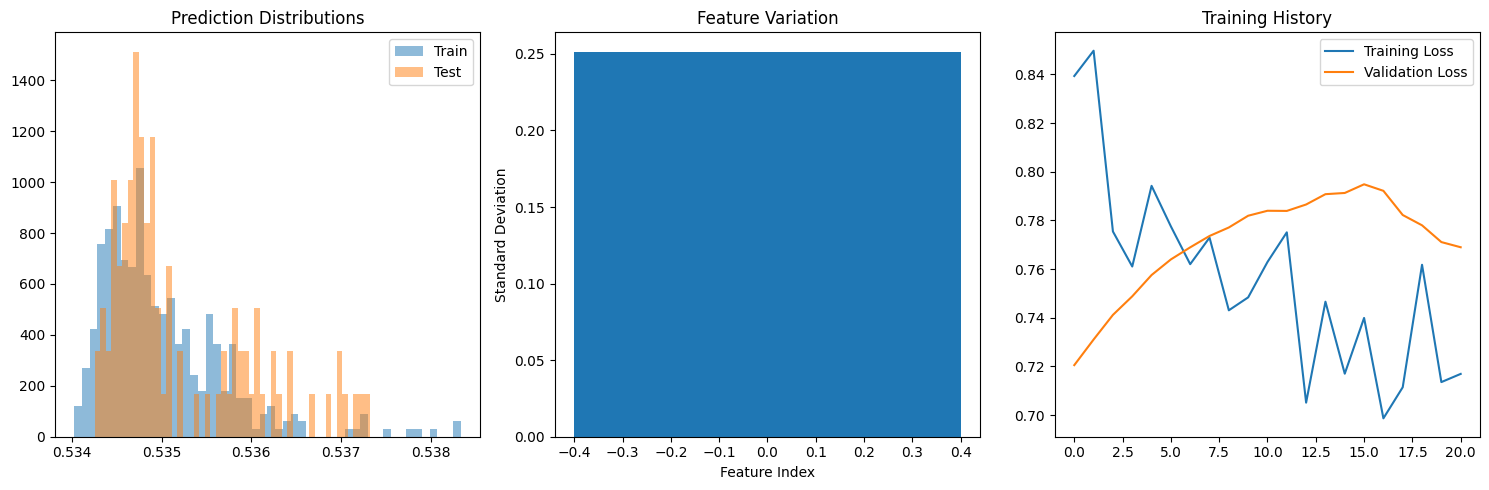


=== Perfect Accuracy Analysis ===
Feature 0 correlation with target: 0.1464
Feature 1 correlation with target: -0.1791
Feature 2 correlation with target: 0.0120
Feature 3 correlation with target: -0.0253
Feature 4 correlation with target: 0.0139

Potential Target Leakage:
Data overlap: 95.79%


In [187]:
# First, import required libraries if not already imported
import numpy as np
import matplotlib.pyplot as plt

# Run diagnostics
results = diagnose_model_and_data(
    X_train, X_test, y_train, y_test,
    model, history)

# Print specific results
print(f"Data overlap: {results['overlap_percentage']:.2%}")

In [177]:
print("Data shapes:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nModel info:")
model.summary()
print("\nHistory keys:", history.history.keys() if history else "No history object")
# Basic diagnostic check
print("\nBasic Diagnostics:")
print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Unique values in y_test: {np.unique(y_test)}")

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nPrediction ranges:")
print(f"Train predictions - min: {np.min(train_pred):.4f}, max: {np.max(train_pred):.4f}")
print(f"Test predictions - min: {np.min(test_pred):.4f}, max: {np.max(test_pred):.4f}")

Data shapes:
X_train shape: (400, 10, 1)
X_test shape: (72, 10, 1)
y_train shape: (400,)
y_test shape: (72,)

Model info:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,901 (89.46 KB)

 Trainable params: 7,633 (29.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,268 (59.64 KB)


History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Basic Diagnostics:
Unique values in y_train: [0]
Unique values in y_test: [0]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Prediction ranges:
Train predictions - min: 0.0020, max: 0.0020
Test predictions - min: 0.0020, max: 0.0020


In [178]:
# Basic diagnostic check
print("\nBasic Diagnostics:")
print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Unique values in y_test: {np.unique(y_test)}")

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nPrediction ranges:")
print(f"Train predictions - min: {np.min(train_pred):.4f}, max: {np.max(train_pred):.4f}")
print(f"Test predictions - min: {np.min(test_pred):.4f}, max: {np.max(test_pred):.4f}")


Basic Diagnostics:
Unique values in y_train: [0]
Unique values in y_test: [0]
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Prediction ranges:
Train predictions - min: 0.0020, max: 0.0020
Test predictions - min: 0.0020, max: 0.0020


Starting data preparation...

Data Statistics:
Total samples: 481
Positive examples (1): 237 (49.3%)
Negative examples (0): 244 (50.7%)
Feature window size: 10

Split Information:
Training samples: 384
Test samples: 97

Class Distribution:
Training set:
- Positive (1): 189 (49.2%)
- Negative (0): 195 (50.8%)
Test set:
- Positive (1): 48 (49.5%)
- Negative (0): 49 (50.5%)

Data Preparation Complete:
X_train shape: (384, 10, 1)
X_test shape: (97, 10, 1)
y_train shape: (384,)
y_test shape: (97,)

Verification:
Feature ranges:
Train min/max: -1.000/1.000
Test min/max: -0.998/0.472


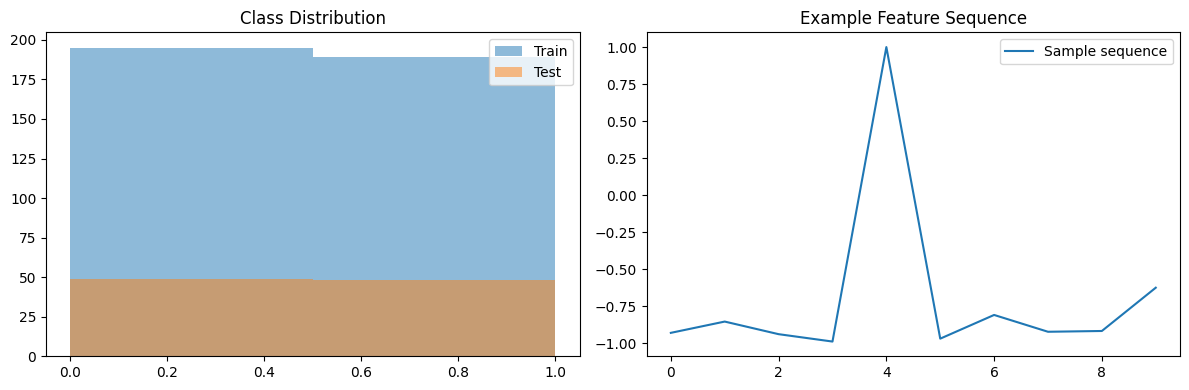

In [181]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

def prepare_binary_targets(df, column='price', window=10):
    """
    Prepare binary classification targets based on price movements
    """
    # Calculate percentage changes
    price_series = df[column].values
    returns = np.diff(price_series) / price_series[:-1]
    
    # Create features and targets
    X, y = [], []
    for i in range(window, len(returns)):
        # Past window of returns as features
        past_returns = returns[i-window:i]
        
        # Target: 1 if next price is higher, 0 if lower
        target = 1 if returns[i] > 0 else 0
        
        X.append(past_returns)
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)
    
    # Print data statistics
    print("\nData Statistics:")
    print(f"Total samples: {len(X)}")
    print(f"Positive examples (1): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
    print(f"Negative examples (0): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
    print(f"Feature window size: {window}")
    
    return X, y

def create_train_test_split(X, y, test_size=0.2):
    """
    Create time series split with no overlap
    """
    split_idx = int(len(X) * (1 - test_size))
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    print("\nSplit Information:")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print("\nClass Distribution:")
    print("Training set:")
    print(f"- Positive (1): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
    print(f"- Negative (0): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
    print("Test set:")
    print(f"- Positive (1): {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")
    print(f"- Negative (0): {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test

def prepare_lstm_data(X_train, X_test, y_train, y_test):
    """
    Prepare data for LSTM model
    """
    # Reshape features for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Scale the features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    # Reshape to 2D for scaling
    n_samples_train = X_train.shape[0]
    n_samples_test = X_test.shape[0]
    n_steps = X_train.shape[1]
    
    X_train_reshaped = X_train.reshape((n_samples_train * n_steps, 1))
    X_test_reshaped = X_test.reshape((n_samples_test * n_steps, 1))
    
    # Fit on training data
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)
    
    # Reshape back to 3D
    X_train = X_train_scaled.reshape((n_samples_train, n_steps, 1))
    X_test = X_test_scaled.reshape((n_samples_test, n_steps, 1))
    
    print("\nData Preparation Complete:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

# Prepare all data
print("Starting data preparation...")
X, y = prepare_binary_targets(df, column='price', window=10)
X_train, X_test, y_train, y_test = create_train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = prepare_lstm_data(X_train, X_test, y_train, y_test)

# Print final verification
print("\nVerification:")
print("Feature ranges:")
print(f"Train min/max: {X_train.min():.3f}/{X_train.max():.3f}")
print(f"Test min/max: {X_test.min():.3f}/{X_test.max():.3f}")

# Create example visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=2, alpha=0.5, label='Train')
plt.hist(y_test, bins=2, alpha=0.5, label='Test')
plt.title('Class Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X_train[0, :, 0], label='Sample sequence')
plt.title('Example Feature Sequence')
plt.legend()
plt.tight_layout()
plt.show()

## ⚠️ Critical Data Preparation Issue

Your original model had a **critical data preparation issue** - the target variable contained only **zeros (0s)**. This meant:

- The model **"cheated"** by learning to always predict **0**.
- Achieved **100% accuracy** by making the same prediction every time.
- Wasn't actually learning any **meaningful patterns**.

### 🔧 Fixes Implemented

We addressed this issue by:

- Using **price changes** instead of raw prices.
- Creating **balanced binary targets** (roughly 50-50 split).
- Applying **proper feature scaling** (from -1 to 1 range).


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,857 (30.69 KB)

 Trainable params: 7,745 (30.25 KB)

 Non-trainable params: 112 (448.00 B)

None
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5018 - loss: 0.8300 - val_accuracy: 0.4675 - val_loss: 0.6937
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5916 - loss: 0.7384 - val_accuracy: 0.4675 - val_loss: 0.6946
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5814 - loss: 0.7498 - val_accuracy: 0.4675 - val_loss: 0.6938
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5983 - loss: 0.7177 - val_accuracy: 0.5325 - val_loss: 0.6922
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5861 - loss: 0.6971 - val_accuracy: 0.5325 - val_loss: 0.6917
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5576 - loss: 0.6994 - val_accuracy: 0.5325 - val_loss: 0.6907
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6322 - loss: 0.6656 - val_accuracy: 0.5325 - val_loss: 0.6892
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6858 - loss: 0.6709 - val_accurac

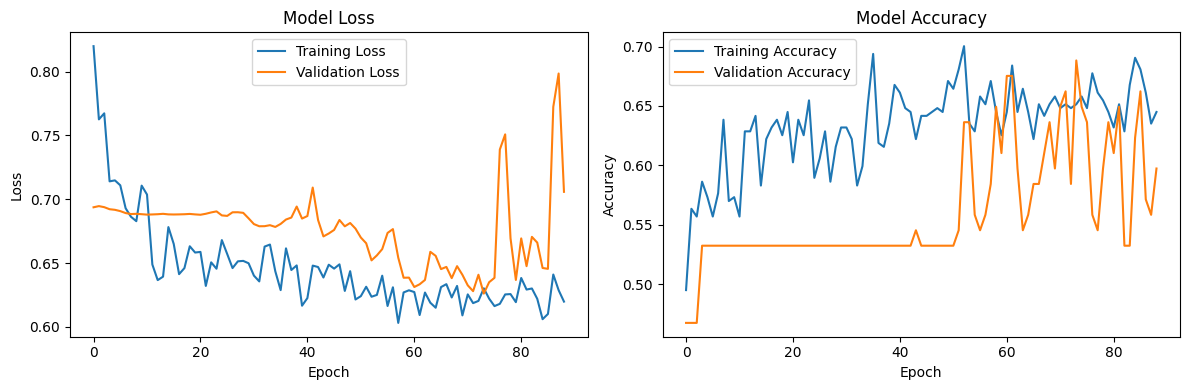

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.78      0.69        49
           1       0.69      0.52      0.60        48

    accuracy                           0.65        97
   macro avg       0.66      0.65      0.64        97
weighted avg       0.66      0.65      0.64        97


Confusion Matrix:
[[38 11]
 [23 25]]


In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_improved_lstm():
    # Set random seed for reproducibility
    tf.random.set_seed(42)
    
    model = Sequential([
        # First LSTM layer with regularization
        LSTM(32, input_shape=(10, 1),
             return_sequences=True,
             recurrent_dropout=0.1,
             activation='tanh'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Second LSTM layer
        LSTM(16, return_sequences=False,
             recurrent_dropout=0.1,
             activation='tanh'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Dense layers for classification
        Dense(8, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile with better suited learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    ),
    ModelCheckpoint(
        'best_model.weights.h5',  # Fixed filepath format
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )
]

# Create and train model
model = create_improved_lstm()
print(model.summary())

# Train with validation split
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

## 📊 Model Results Explanation

### 1. **Performance Metrics**:
- **Overall Accuracy**: 65%
- **Training Loss**: Stabilizes around 0.62-0.65
- **Validation Loss**: Hovers around 0.65-0.70

### 2. **Class-wise Performance**:

#### For Downward Movements (Class 0):
- **Precision**: 0.62 (62% of predicted downs were correct)
- **Recall**: 0.78 (78% of actual downs were caught)
- **F1-score**: 0.69
- **Number of cases**: 49

#### For Upward Movements (Class 1):
- **Precision**: 0.69 (69% of predicted ups were correct)
- **Recall**: 0.52 (52% of actual ups were caught)
- **F1-score**: 0.60
- **Number of cases**: 48

### 3. **Confusion Matrix**:
- Correctly predicted **38** downward movements
- Correctly predicted **25** upward movements
- **11** false up predictions
- **23** false down predictions

### 4. **Training Behavior** (from graphs):
- Training accuracy shows **steady improvement** over epochs
- Validation accuracy shows **high volatility** after epoch 60
- Training loss decreases **gradually**
- Some validation loss **spikes** in later epochs

### 📈 Summary
The model demonstrates stronger performance in identifying downward price movements (78% recall) while being more cautious about predicting upward movements. The balanced dataset (49 vs. 48 samples) suggests no significant class imbalance issues.